# pa005: High Value Customer Identification (Insiders)

## Solution Plan (IOT)

 ### 0.1. Input

1. Business problem
    - Select the most valuable costumers to join a loyalty program called "Insiders"
    

2. Data
    - Sales during the period of one year

 ### 0.2. Output

1. Refer some people elegible to be part of the loyalty program
            | client_id | is_insider | 
            | 20394     | yes(1)     |
            | 23948     | no (0)     |

 ### 0.3. Tasks

1. who are the people eligible for the loyalty program?
    - What does "being elegible" mean? Who are the "valuable customers"?
        - Invoicing:
            - High ATP
            - High LTV
            - Low recency
            - High basket size
            - Low probability of churn
        - Cost:
            - Low product return rate
        - Shopping Experience:       
            - High average rating
            
        
2. How many customers will be able to join the group?
    - Total number of customers
    - % Insiders Group
3. What are the main features of these customers?
        -  Age
        - Location
4. How much do the Insiders contribute to the total billing amount?
    - Total billing amout
    - % Insiders billing
5. Whet is the Insider's billing forecast for the coming months?
    - LTV Insiders group
    - Cohort analysis
6. What are the conditions to someone be elegible to the Insiders group?
    - The person has to be similar to the others in the group
8. How to ensure that the Insiders program is better than the current model?
    - A/B test
    - Bayesian A/B test
    - Hypotesis test
9. What are the marketing plans for this group?
    - Discounts
    - Purchase preference
    - Free shipping

# 0.0. Imports

In [151]:
import pandas as pd
import numpy as np
import seaborn as sns
import re

from IPython.display         import Image

from matplotlib              import pyplot       as plt
from matplotlib              import gridspec
from plotly                  import express      as px
from IPython.display         import HTML

from dataprep.eda            import create_report
from dataprep.connector      import info_ui

import hdbscan
import umap.umap_                                 as umap

from sklearn                 import cluster       as c
from sklearn                 import metrics       as m
from sklearn                 import preprocessing as pp
from sklearn                 import decomposition as dd
from sklearn.manifold        import TSNE
from sklearn.ensemble        import RandomForestRegressor
from sklearn.neighbors       import NearestNeighbors
from scipy.cluster           import hierarchy     as hc

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

import warnings
warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [246]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )


    sns.set()
jupyter_settings()

def get_silhouettes( data, labels ):
    
    silhouette_scores = []

    for label in labels:

        # model performance
            sil = m.silhouette_score( data, label, metric = 'euclidean' )
            silhouette_scores.append( np.round(sil,2) )
    
    return silhouette_scores

def plot_clusters( data, k, labels ):
    
    data = data.copy()
    data.columns = ['embedding_x', 'embedding_y']
    
    nrows = len(k) // 4 if len(k) % 4 == 0 else (len(k)//4) + 1
    fig = plt.figure(figsize = (21,18) ) 
    specs = gridspec.GridSpec( ncols = 4, nrows = nrows, figure = fig, wspace = .3, hspace = .3 )
    
    plots = []
    
    silhouettes = get_silhouettes( data, labels)
    
    for i in range(nrows):
        for j in range(4):
            ax = fig.add_subplot( specs[ i, j ] )
            plots.append( ax )
    
    for i in range(len( k )):
       
        # model evaluation
        sil = silhouettes[i]
        
        data['cluster'] = labels[i]
        
        sns.scatterplot(data = data, x='embedding_x',y='embedding_y', 
                        hue = 'cluster', palette = 'deep', 
                        ax = plots[i], legend = False)
        
        
        title = "Num. Clusters = " + str(k[i]) + " | Silhouette Score: " + str(np.round(sil,2))
        plots[i].set_title( title )
        plots[i].set_xlabel(xlabel = "")
        plots[i].set_ylabel(ylabel = "")

        
def best_silhouette( data, k, labels ):
    
    silhouettes = get_silhouettes( data = data, labels = labels )

    plt.figure( figsize = ( 10, 6 ))
    plt.plot( k, silhouettes, linestyle = '--', marker = 'o', color = 'b')
    plt.xlabel( 'K' );
    plt.ylabel( 'Silhouette Score' );
    plt.title( 'Silhouette Score x K' );
    

def plot_cluster_silhouette(X, labels, k):
    
    fig, ax = plt.subplots( 1, 1 )
    fig.set_size_inches( 8, 7 )

    ax.set_xlim( [ -0.1, 1 ] )
    ax.set_ylim( [ 0, len( X ) + ( k + 1 ) * 10] )
    
    samples_silhouette_values = m.silhouette_samples( X, labels )

    y_lower = 10
    for i in range( k ):

        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[ labels == i]
        
        # sort values
        ith_samples_silhouette_values.sort()

        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = plt.get_cmap( 'Spectral' )
        color = cmap( i / k )

        ax.fill_betweenx( np.arange( y_lower, y_upper ), 0, ith_samples_silhouette_values  )
        
        y_lower = y_upper + 10

    ax.set_yticks([])
    ax.set_xticks( [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.legend( np.unique(labels) )
    ax.set_title(" Clusters Silhouettes")

## 0.2 Loading Dataset

In [3]:
# Load data
ecommerce = pd.read_csv('../data/Ecommerce.csv',encoding='latin1')

# Drop extra column
ecommerce = ecommerce.iloc[:,:-1]

# 1.0. Data description

In [4]:
ecommerce1 = ecommerce.copy()

## 1.1. Rename Columns

In [5]:
new_cols =  ['invoice_no', 'stock_code','description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
ecommerce1.columns = new_cols

## 1.2. Data Dimensions

In [6]:
ecommerce1.shape

(541909, 8)

## 1.3. Data types

In [7]:
ecommerce1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [8]:
ecommerce1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [9]:
# Missing values on customer ID
ecommerce_missing = ecommerce1[ecommerce1['customer_id'].isna()]
ecommerce_not_missing = ecommerce1[~ecommerce1['customer_id'].isna()]

In [10]:
ecommerce_missing_customerid = ecommerce_missing[['invoice_no','customer_id']].drop_duplicates()
ecommerce_missing_customerid['customer_id'] = np.arange( 19000, 19000 + len(ecommerce_missing_customerid), 1 )
ecommerce_missing = pd.merge(ecommerce_missing.drop('customer_id', axis = 1), ecommerce_missing_customerid, on = 'invoice_no', how = 'left')
ecommerce_missing = ecommerce_missing[ecommerce_not_missing.columns]
ecommerce1 = pd.concat([ecommerce_missing, ecommerce_not_missing])

In [11]:
# Drop description column
ecommerce1 = ecommerce1.drop('description', axis = 1)

In [12]:
ecommerce1.isna().sum()

invoice_no      0
stock_code      0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6. Change Dtypes

In [13]:
# Invoice date
ecommerce1['invoice_date'] = pd.to_datetime(ecommerce1['invoice_date'], format = '%d-%b-%y')

# Customer id
ecommerce1['customer_id'] = ecommerce1['customer_id'].astype(np.int64)

In [14]:
ecommerce1.sort_values('invoice_no').head()

invoice_no stock_code  quantity invoice_date  unit_price  customer_id  \
0     536365     85123A         6   2016-11-29        2.55        17850   
6     536365      21730         6   2016-11-29        4.25        17850   
5     536365      22752         2   2016-11-29        7.65        17850   
1     536365      71053         6   2016-11-29        3.39        17850   
3     536365     84029G         6   2016-11-29        3.39        17850   

          country  
0  United Kingdom  
6  United Kingdom  
5  United Kingdom  
1  United Kingdom  
3  United Kingdom

## 1.7. Drop Duplicates

In [15]:
#ecommerce1 = ecommerce1.drop_duplicates()

## 1.8. Descriptive Statistics

In [16]:
num_attributes = ecommerce1.select_dtypes( include = ['int64', 'float64'])
cat_attributes = ecommerce1.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.8.1. Numerical Attributes

In [17]:
# Central tendency (mean, median)
ct1 = ( num_attributes.apply( np.mean ) ).T
ct2 = ( num_attributes.apply( np.median ) ).T
# Dispersion ( std, min, max. range, skew, kurtosis)
d1 = ( num_attributes.apply( np.std ) ).T
d2 = ( num_attributes.apply( np.min ) ).T
d3 = ( num_attributes.apply( np.max ) ).T
d4 = ( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = ( num_attributes.apply( lambda x: x.max() - x.skew() ) ).T
d6 = ( num_attributes.apply( lambda x: x.max() - x.kurtosis() ) ).T

# Concatenate
ecommerce_stats = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6], axis = 1 ).reset_index()
ecommerce_stats.columns = ['attributes','min','max', 'range', 'mean', 'median',' std',' skew', 'kurtosis']
ecommerce_stats

attributes       min      max      range          mean    median  \
0     quantity -80995.00  80995.0  161990.00      9.552250      3.00   
1   unit_price -11062.06  38970.0   50032.06      4.611114      2.08   
2  customer_id  12346.00  22709.0   10363.00  16688.840453  16249.00   

           std          skew      kurtosis  
0   218.080957  80995.264076 -38774.160031  
1    96.759764  38783.493028 -20035.719097  
2  2911.408666  22708.512551  22709.804287

#### 1.8.1.1. Numerical attributes - Investigating

In [18]:
# Negative values for quantity
# Negative values for unit price

### 1.8.2. Categorical Attributes

##### Invoice Number

In [19]:
 # Invoice number
invoices_w_letters = ecommerce1.loc[ecommerce1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), : ]
negative_quantity = len( invoices_w_letters.loc[invoices_w_letters['quantity'] < 0, : ] )
print('Total number of invoices number with letter: ',len( invoices_w_letters ), '\nTotal number of negative quantity: ', negative_quantity)

Total number of invoices number with letter:  9291 
Total number of negative quantity:  9288


##### Stock code

In [20]:
# Stock code
# Check only characters on stock code
ecommerce1.loc[ecommerce1['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$',  x ) ) ), 'stock_code' ].unique()

# Action: Remove stock code in ['DOT', 'M', 'S', 'AMAZONFEE', 'm', 'POST', 'DCGSSBOY', 'DCGSSGIRL', 'B', 'D', 'PADS', 'CRUK']


array(['DOT', 'M', 'S', 'AMAZONFEE', 'm', 'POST', 'DCGSSBOY', 'DCGSSGIRL',
       'B', 'D', 'PADS', 'CRUK'], dtype=object)

##### Description

In [21]:
# Action: delete description

##### Country

In [22]:
ecommerce1['country'].unique()

array(['United Kingdom', 'EIRE', 'Bahrain', 'Israel', 'Hong Kong',
       'Unspecified', 'France', 'Switzerland', 'Portugal', 'Australia',
       'Netherlands', 'Germany', 'Norway', 'Spain', 'Poland', 'Italy',
       'Belgium', 'Lithuania', 'Japan', 'Iceland', 'Channel Islands',
       'Denmark', 'Cyprus', 'Sweden', 'Austria', 'Finland', 'Greece',
       'Singapore', 'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Brazil', 'USA', 'European Community',
       'Malta', 'RSA'], dtype=object)

In [23]:
ecommerce1['country'].value_counts(normalize = True)

United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
European C

In [24]:
ecommerce1[['customer_id','country']].drop_duplicates().groupby('country').count().reset_index().sort_values(by = 'customer_id', ascending = False).head(4)

country  customer_id
36  United Kingdom         7587
14         Germany           95
13          France           90
10            EIRE           44

# 2.0. Data Filtering

In [25]:
ecommerce2 = ecommerce1

In [26]:
# Categorical attributes

# Stock code
ecommerce2 = ecommerce2[~ecommerce2['stock_code'].isin(['DOT', 'M', 'S', 'AMAZONFEE', 'm', 'POST', 'DCGSSBOY', 'DCGSSGIRL', 'B', 'D', 'PADS', 'CRUK'])]

# Country
ecommerce2 = ecommerce2[~ecommerce2['country'].isin( ['European Community', 'Unspecified'] )] 

# Numerical attributes

# Unit price
ecommerce2 = ecommerce2[ecommerce2['unit_price'] >= 0.04]

# Bad users
ecommerce2 = ecommerce2[~ecommerce2['customer_id'].isin( [16446] )]

# Quantity
ecommerce_returns = ecommerce2.loc[ecommerce2['quantity'] < 0, : ] 
ecommerce_purchases = ecommerce2.loc[ecommerce2['quantity'] >= 0, : ] 

# 3.0. Feature Engineering

In [27]:
ecommerce3 = ecommerce2

In [28]:
customer_df = ecommerce3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis = 1).drop_duplicates(ignore_index = True)

## 3.1. Feature Creation

### 3.1.1. Gross Revenue

In [29]:
# Gross Revenue
ecommerce_purchases['gross_revenue'] = ecommerce_purchases['quantity'] * ecommerce_purchases['unit_price']
df_gross_revenue = ecommerce_purchases[['gross_revenue','customer_id']].groupby('customer_id').sum().reset_index()
customer_df = pd.merge(customer_df, df_gross_revenue,on = 'customer_id', how = 'left')

customer_df.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2. Recency

In [30]:
# Recency - Last day purchase
df_recency = ecommerce_purchases[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency'] = (ecommerce_purchases['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id','recency']].copy()

# Merge
customer_df = pd.merge(customer_df, df_recency, on = 'customer_id', how = 'left')

customer_df.isna().sum()

customer_id       0
gross_revenue    91
recency          91
dtype: int64

### 3.1.3. Quantity of purchases

In [31]:
# qtty purchased
df_frequency = ecommerce_purchases[['invoice_no', 'customer_id']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns = {'invoice_no' : 'qtty_invoices'})

# Merge
customer_df = pd.merge(customer_df, df_frequency, on = 'customer_id', how = 'left')
customer_df.isna().sum()

customer_id       0
gross_revenue    91
recency          91
qtty_invoices    91
dtype: int64

### 3.1.4. Quantity of items purchased

In [32]:
# qtty purchased
df_products = ecommerce_purchases[['quantity', 'customer_id']].groupby('customer_id').sum().reset_index().rename(columns = {'quantity' : 'qtty_items'})

# Merge
customer_df = pd.merge(customer_df, df_products, on = 'customer_id', how = 'left')

customer_df.isna().sum()

customer_id       0
gross_revenue    91
recency          91
qtty_invoices    91
qtty_items       91
dtype: int64

### 3.1.5. Quantity of products purchased

In [33]:
# qtty purchased
df_products = ecommerce_purchases[['stock_code', 'customer_id']].groupby('customer_id').count().reset_index().rename(columns = {'stock_code' : 'qtty_products'})

# Merge
customer_df = pd.merge(customer_df, df_products, on = 'customer_id', how = 'left')

customer_df.isna().sum()

customer_id       0
gross_revenue    91
recency          91
qtty_invoices    91
qtty_items       91
qtty_products    91
dtype: int64

### 3.1.6. Average Ticket

In [34]:
# AVG Ticket
df_avgticket = ecommerce_purchases[['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns = {'gross_revenue':'avg_ticket'})

# Merge
customer_df = pd.merge(customer_df, df_avgticket, on = 'customer_id', how = 'left')

customer_df.isna().sum()

customer_id       0
gross_revenue    91
recency          91
qtty_invoices    91
qtty_items       91
qtty_products    91
avg_ticket       91
dtype: int64

### 3.1.7. Average Recency Days

In [35]:
# AVG Recency days
aux_recency = ecommerce2[['customer_id','invoice_date']].drop_duplicates().sort_values( ['customer_id','invoice_date'], ascending = [True, True])
aux_recency['next_customer_id'] = aux_recency['customer_id'].shift()
aux_recency['previous_date'] = aux_recency['invoice_date'].shift()
aux_recency['avg_recency_days'] = aux_recency.apply( lambda x:( ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan), axis = 1 )
aux_recency = aux_recency.drop( ['invoice_date','next_customer_id','previous_date'], axis = 1).dropna()
aux_recency = aux_recency.groupby('customer_id').mean().reset_index()

# Merge
customer_df = pd.merge(customer_df, aux_recency, on = 'customer_id', how = 'left')

customer_df.isna().sum()

customer_id            0
gross_revenue         91
recency               91
qtty_invoices         91
qtty_items            91
qtty_products         91
avg_ticket            91
avg_recency_days    2816
dtype: int64

### 3.1.8. Fequecy Purchase

In [36]:
# Frquency purchase
frequency_df = (
                ecommerce2[['customer_id','invoice_no', 'invoice_date']].drop_duplicates()
                                                                        .groupby('customer_id')
                                                                        .agg( max_date = ('invoice_date', 'max'),
                                                                              min_date = ('invoice_date', 'min'),
                                                                              qtty_purchases = ('invoice_no', 'count')     
                                                                            ).reset_index()
              )
frequency_df['date_interval'] = ((frequency_df['max_date'] - frequency_df['min_date']).dt.days)
frequency_df['frequency'] = frequency_df.apply(lambda x: ( x['qtty_purchases'] / x['date_interval'] ) if x['date_interval'] != 0 else 0, axis = 1 )

# Merge
customer_df = pd.merge(customer_df, frequency_df[['customer_id','frequency']], on = 'customer_id', how = 'left')

customer_df.isna().sum()

customer_id            0
gross_revenue         91
recency               91
qtty_invoices         91
qtty_items            91
qtty_products         91
avg_ticket            91
avg_recency_days    2816
frequency              0
dtype: int64

### 3.1.9. Returns

In [37]:
# Number of returns
customer_returns = ecommerce_returns[['customer_id','quantity']].groupby('customer_id').sum().reset_index().rename(columns = {'quantity' : 'qtty_returns'})
customer_returns['qtty_returns'] = customer_returns['qtty_returns'] * - 1

# Merge
customer_df = pd.merge(customer_df, customer_returns, on = 'customer_id', how = 'left')
customer_df.loc[customer_df['qtty_returns'].isna(),'qtty_returns'] = 0

customer_df.isna().sum()

customer_id            0
gross_revenue         91
recency               91
qtty_invoices         91
qtty_items            91
qtty_products         91
avg_ticket            91
avg_recency_days    2816
frequency              0
qtty_returns           0
dtype: int64

### 3.1.10. Basket Size

In [38]:
basket_size = (ecommerce_purchases[['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                 .agg(invoices = ('invoice_no','nunique'),
                                                                      products = ('quantity','sum')).reset_index() 
                
)

basket_size['basket_size'] = basket_size['products'] / basket_size['invoices']

# Merge
customer_df = pd.merge(customer_df, basket_size[['customer_id','basket_size']], on = 'customer_id', how = 'left')

customer_df.isna().sum()

customer_id            0
gross_revenue         91
recency               91
qtty_invoices         91
qtty_items            91
qtty_products         91
avg_ticket            91
avg_recency_days    2816
frequency              0
qtty_returns           0
basket_size           91
dtype: int64

### 3.1.11. Unique Basket Size

In [39]:
avg_basket_size = ( ecommerce_purchases[['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                                 .agg( invoices = ('invoice_no','nunique'),
                                                                       products = ('stock_code','nunique') ).reset_index() 
                
                  )

avg_basket_size['unique_basket_size'] = avg_basket_size['products'] / avg_basket_size['invoices']
# Merge
customer_df = pd.merge(customer_df, avg_basket_size[['customer_id','unique_basket_size']], on = 'customer_id', how = 'left')

customer_df.isna().sum()

customer_id              0
gross_revenue           91
recency                 91
qtty_invoices           91
qtty_items              91
qtty_products           91
avg_ticket              91
avg_recency_days      2816
frequency                0
qtty_returns             0
basket_size             91
unique_basket_size      91
dtype: int64

# 4.0. Univariate & Bivariate Analysis

In [40]:
ecommerce4 = customer_df.dropna().copy()

## 4.1. Univariate Analysis

Metrics: min, max, range, dispertion

         men, median 
         
         std, variance
         
         coefficient of variation (cv)
         
         distribution
         
Conclusions:

Gross Revenue - ok

Recency - ok

Qtty invoices - ok

Qtty intems

Qtty products


  0%|                                                  | 0/2423 [00:00<?, ?it/s]


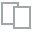
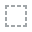
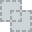
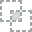
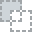
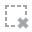
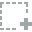
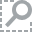
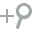
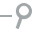
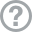
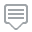
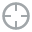
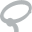
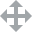
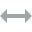
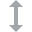
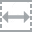
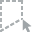
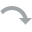
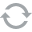
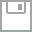
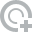
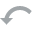
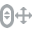
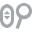
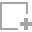
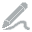
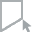
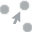
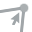
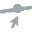

In [41]:
report = create_report(ecommerce4).show()

### 4.1.1. Gross Revenue

In [42]:
ecommerce4.sort_values('gross_revenue', ascending = False).head(5)

customer_id  gross_revenue  recency  qtty_invoices  qtty_items  \
2338        14646      279138.02      1.0           72.0    196844.0   
1879        18102      259657.30      0.0           60.0     64124.0   
1831        17450      194550.79      8.0           46.0     69993.0   
1496        14911      140450.72      1.0          199.0     80263.0   
2409        12415      124564.53     24.0           20.0     77373.0   

      qtty_products  avg_ticket  avg_recency_days  frequency  qtty_returns  \
2338         2060.0  135.503893          7.844444   0.206799         288.0   
1879          431.0  602.453132         14.680000   0.163488           0.0   
1831          337.0  577.302047         12.821429   0.136490         952.0   
1496         5673.0   24.757751          2.601399   0.653226        3332.0   
2409          713.0  174.704811         20.866667   0.076677         427.0   

      basket_size  unique_basket_size  
2338  2733.944444            9.708333  
1879  1068.733333            2.500000  
1831  1521.586957            2.695652  
1496   403.331658            8.974874  
2409  3868.650000           22.150000

### 4.1.2. Qtty Products

In [43]:
ecommerce4[ecommerce4['qtty_products'] == 7667]

Empty DataFrame
Columns: [customer_id, gross_revenue, recency, qtty_invoices, qtty_items, qtty_products, avg_ticket, avg_recency_days, frequency, qtty_returns, basket_size, unique_basket_size]
Index: []

### 4.1.3. AVG Ticket

In [44]:
ecommerce4.sort_values('avg_ticket', ascending = False).head(5)

customer_id  gross_revenue  recency  qtty_invoices  qtty_items  \
2505        15749       44534.30    235.0            3.0     18028.0   
2942        18087        3202.92    290.0            1.0      3906.0   
2399        16532        6748.80     17.0            3.0      2016.0   
1982        12755        3811.95    280.0            2.0      1491.0   
4368        12798        6977.04     10.0            3.0      5256.0   

      qtty_products  avg_ticket  avg_recency_days  frequency  qtty_returns  \
2505           10.0   4453.4300              97.0   0.041237        9014.0   
2942            1.0   3202.9200              78.5   0.019108         336.0   
2399            4.0   1687.2000             160.5   0.009346           0.0   
1982            4.0    952.9875              58.0   0.025862         624.0   
4368            8.0    872.1300              80.0   0.018750           0.0   

      basket_size  unique_basket_size  
2505  6009.333333            1.666667  
2942  3906.000000            1.000000  
2399   672.000000            0.666667  
1982   745.500000            2.000000  
4368  1752.000000            2.000000

In [45]:
ecommerce[ecommerce['CustomerID'] == 16446] # Action: remove this customer

InvoiceNo StockCode                  Description  Quantity InvoiceDate  \
194354    553573     22980       PANTRY SCRUBBING BRUSH         1   16-May-17   
194355    553573     22982          PANTRY PASTRY BRUSH         1   16-May-17   
540421    581483     23843  PAPER CRAFT , LITTLE BIRDIE     80995    7-Dec-17   
540422   C581484     23843  PAPER CRAFT , LITTLE BIRDIE    -80995    7-Dec-17   

        UnitPrice  CustomerID         Country  
194354       1.65     16446.0  United Kingdom  
194355       1.25     16446.0  United Kingdom  
540421       2.08     16446.0  United Kingdom  
540422       2.08     16446.0  United Kingdom

### 4.1.4. Frequency

In [46]:
ecommerce4[ecommerce4['frequency'] > 3]

customer_id  gross_revenue  recency  qtty_invoices  qtty_items  \
5663        18139        8438.34     17.0            6.0      5557.0   
5743        15060         301.84      8.0            4.0       262.0   

      qtty_products  avg_ticket  avg_recency_days  frequency  qtty_returns  \
5663          159.0   53.071321               1.0        6.0           0.0   
5743          120.0    2.515333               1.0        4.0           0.0   

      basket_size  unique_basket_size  
5663   926.166667            5.833333  
5743    65.500000           20.000000

### 4.1.5. AVG Basket Size

In [47]:
ecommerce4[ecommerce4['basket_size'] > 4000]

customer_id  gross_revenue  recency  qtty_invoices  qtty_items  \
2505        15749       44534.30    235.0            3.0     18028.0   
4036        12590        9341.26    211.0            1.0      4282.0   

      qtty_products   avg_ticket  avg_recency_days  frequency  qtty_returns  \
2505           10.0  4453.430000              97.0   0.041237        9014.0   
4036           67.0   139.421791              21.0   0.095238           4.0   

      basket_size  unique_basket_size  
2505  6009.333333            1.666667  
4036  4282.000000           67.000000

In [48]:
ecommerce3[ecommerce3['customer_id'].isin([15749,12590])].head(15)

invoice_no stock_code  quantity invoice_date  unit_price  customer_id  \
52709      540815     85123A      1930   2017-01-09        2.55        15749   
52710      540815      21175      2000   2017-01-09        1.85        15749   
52711      540815      21108      3114   2017-01-09        2.10        15749   
52771      540818     47556B      1300   2017-01-09        2.55        15749   
52772      540818      48185       670   2017-01-09        6.75        15749   
160141    C550456      48185      -670   2017-04-16        6.75        15749   
160142    C550456     47566B     -1300   2017-04-16        2.55        15749   
160143    C550456     85123A     -1930   2017-04-16        2.55        15749   
160144    C550456      21175     -2000   2017-04-16        1.85        15749   
160145    C550456      21108     -3114   2017-04-16        2.10        15749   
160542     550461     85123A      1930   2017-04-16        2.40        15749   
160543     550461     47556B      1300   2017-04-16        2.10        15749   
160544     550461      48185       670   2017-04-16        6.35        15749   
160545     550461      21175      2000   2017-04-16        1.69        15749   
160546     550461      21108      3114   2017-04-16        2.10        15749   

               country  
52709   United Kingdom  
52710   United Kingdom  
52711   United Kingdom  
52771   United Kingdom  
52772   United Kingdom  
160141  United Kingdom  
160142  United Kingdom  
160143  United Kingdom  
160144  United Kingdom  
160145  United Kingdom  
160542  United Kingdom  
160543  United Kingdom  
160544  United Kingdom  
160545  United Kingdom  
160546  United Kingdom

## 4.2. Bivariate Analysis

<Figure size 2500x1200 with 0 Axes>

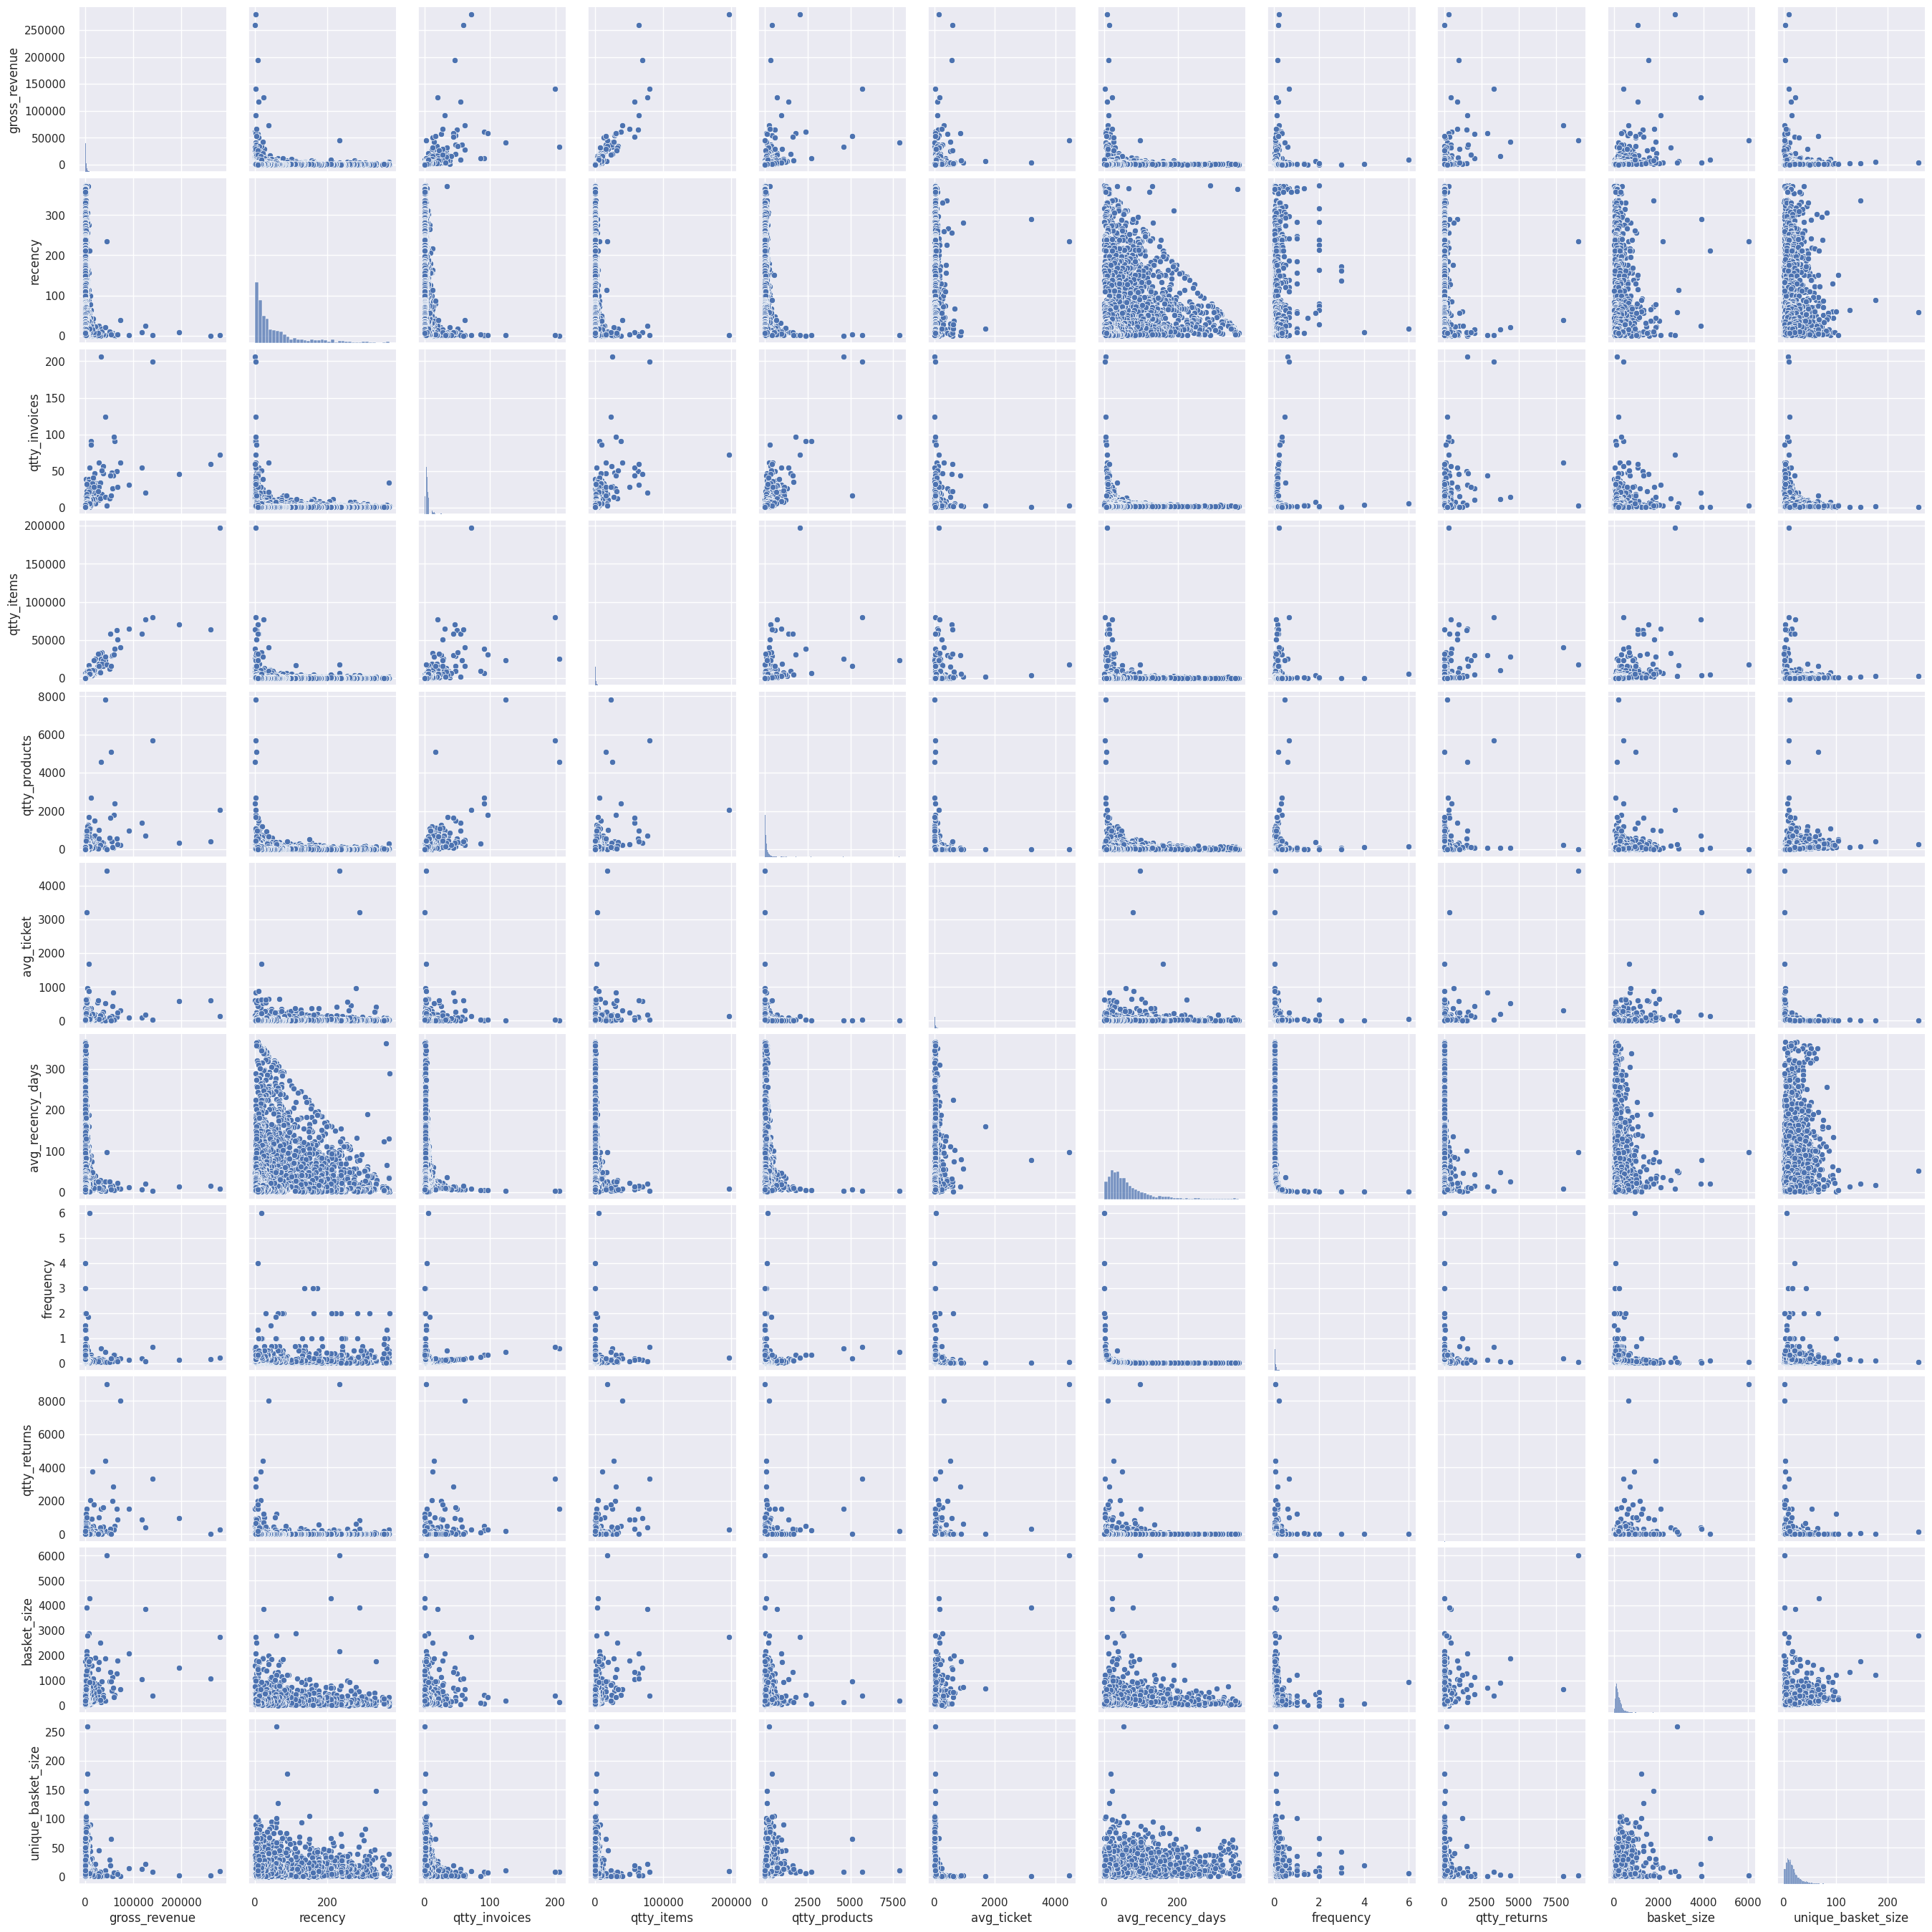

In [49]:
ecommerce_pairplot = ecommerce4.drop('customer_id', axis = 1)
plt.figure( figsize = ( 25, 12 ))
sns.pairplot( ecommerce_pairplot )

- Frequency has low variance
- AVG Ticket has low variance
- Selected columns: 'customer_id', 'gross_revenue', 'recency', 'qtty_products', 'frequency', 'qtty_returns'

# 5.0. Feature Selection

In [50]:
cols_select = ['customer_id','gross_revenue', 'recency', 'qtty_products', 'frequency', 'qtty_returns']
ecommerce4 = ecommerce4[cols_select].copy()

# 5.0. Data Preparation

In [51]:
ecommerce5 = ecommerce4.copy()

## 5.1. Rescaling

In [52]:
# Minmax Scaler
mm = pp.MinMaxScaler() # not normal distribution
ss = pp.StandardScaler() # normal distribution without outliers
rs = pp.RobustScaler() # normal distribution with outliers

ecommerce5['gross_revenue'] = mm.fit_transform(ecommerce5[['gross_revenue']])

ecommerce5['recency']       = mm.fit_transform(ecommerce5[['recency']])

ecommerce5['qtty_products'] = mm.fit_transform(ecommerce5[['qtty_products']])

ecommerce5['frequency']     = mm.fit_transform(ecommerce5[['frequency']])

ecommerce5['qtty_returns']  = mm.fit_transform(ecommerce5[['qtty_returns']])

# 6.0. Space Study

In [53]:
# Selected dataset
ecommerce6 = ecommerce5.copy()
X = ecommerce6.drop('customer_id', axis = 1)

**Selected space: Tree based**

## 6.1. PCA

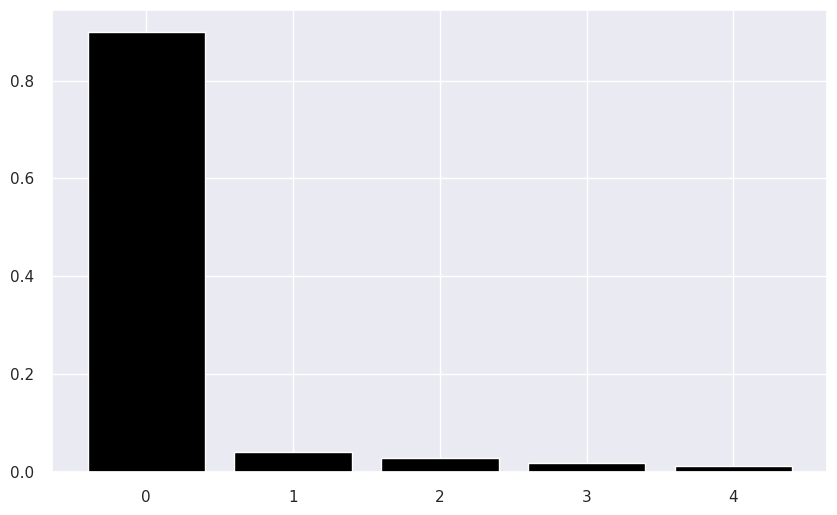

In [54]:
pca = dd.PCA( n_components = X.shape[1] )
principal_components = pca.fit_transform( X )

# Plot explained variable
features = range(pca.n_components_)

plt.figure( figsize = ( 10, 6 ))
plt.bar(features, pca.explained_variance_ratio_, color = 'black')

# pca component
df_pca = pd.DataFrame( principal_components )

<AxesSubplot: xlabel='0', ylabel='1'>

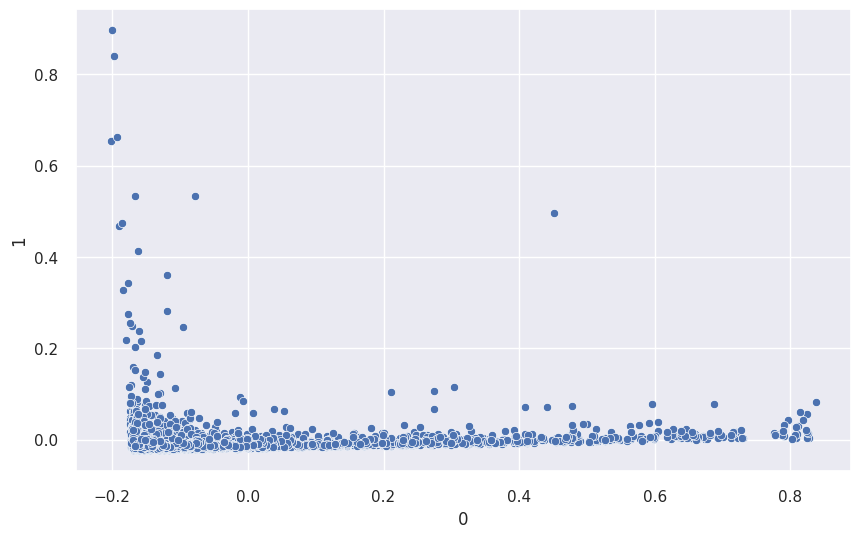

In [55]:
plt.figure( figsize = ( 10, 6 ))
sns.scatterplot( x = 0, y = 1, data = df_pca )

## 6.2. UMAP

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

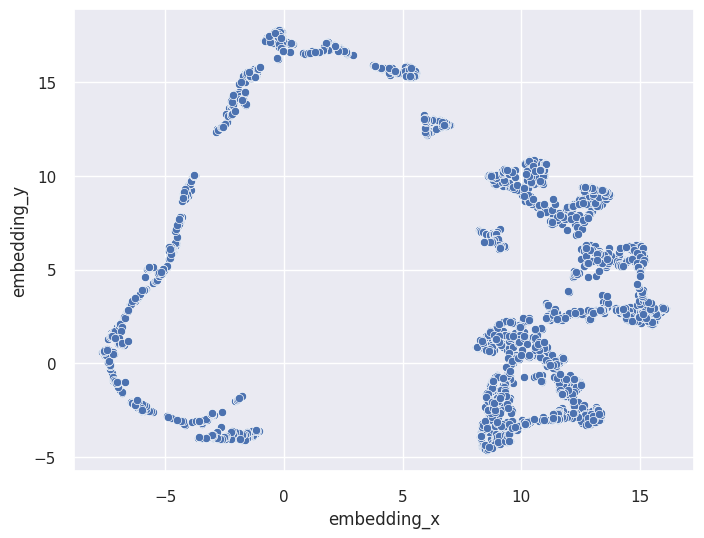

In [56]:
df_umap = pd.DataFrame()
reducer = umap.UMAP( random_state = 42 )
embedding = reducer.fit_transform( X )

# embedding
df_umap['embedding_x'] = embedding[: , 0]
df_umap['embedding_y'] = embedding[: , 1]

# Plot UMAP
plt.figure(figsize=(8, 6))
sns.scatterplot( x = 'embedding_x', y = 'embedding_y',
                 data = df_umap )

## 6.3. t-SNE

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

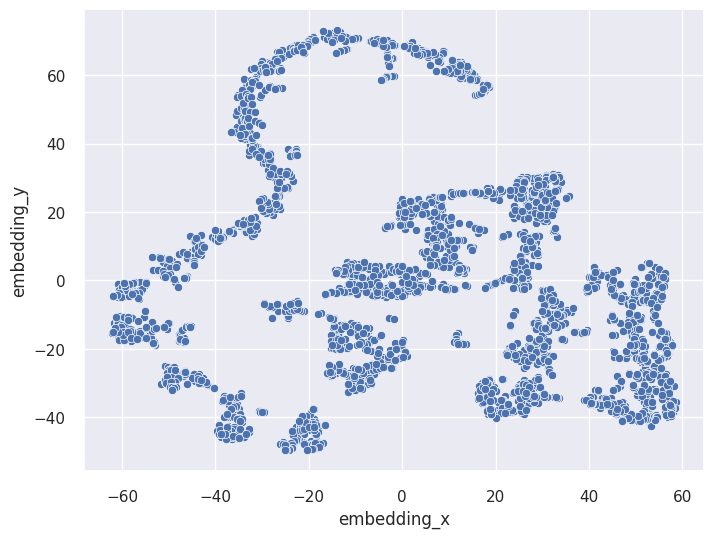

In [57]:
df_tsne = pd.DataFrame()
reducer = TSNE( n_components = 2, random_state = 42, n_jobs = -1 )
embedding = reducer.fit_transform( X )

# embedding
df_tsne['embedding_x'] = embedding[: , 0]
df_tsne['embedding_y'] = embedding[: , 1]

# Plot t-SNE
plt.figure(figsize=(8, 6))
sns.scatterplot( x = 'embedding_x', y = 'embedding_y',
                 data = df_tsne )

## 6.4. Tree-Based Embedding

In [58]:
y = X['gross_revenue']
X = X.drop('gross_revenue', axis = 1)

In [59]:
# Model definition
rf_model = RandomForestRegressor( n_estimators = 100, random_state = 42 )

# Model training
rf_model.fit( X, y )

# Leaf
df_leaf = pd.DataFrame( rf_model.apply( X ) )

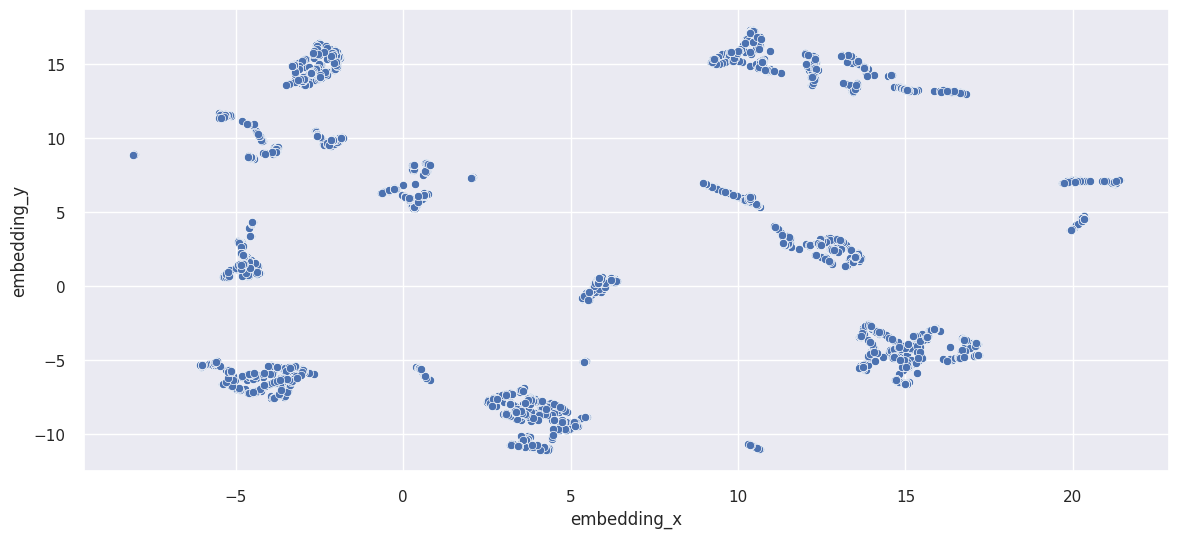

In [60]:
reducer = umap.UMAP( random_state = 42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_leaf['embedding_x'] = embedding[: , 0]
df_leaf['embedding_y'] = embedding[: , 1]


# Plot leaves
plt.figure(figsize=(14, 6))
sns.scatterplot( x = 'embedding_x', y = 'embedding_y',
                 data = df_leaf )

df_leaf = df_leaf [['embedding_x', 'embedding_y']]

# 7.0. Model Selection & Hyperparameter Fine -Tunning

In [61]:
ecommerce7 = df_leaf.copy()
ecommerce7['customer_id'] = ecommerce6['customer_id']
X = ecommerce7.iloc[:,:-1].copy()

In [62]:
clusters = np.arange(2, 18, 1)

## 7.1. Models

### 7.1.1. K-Means

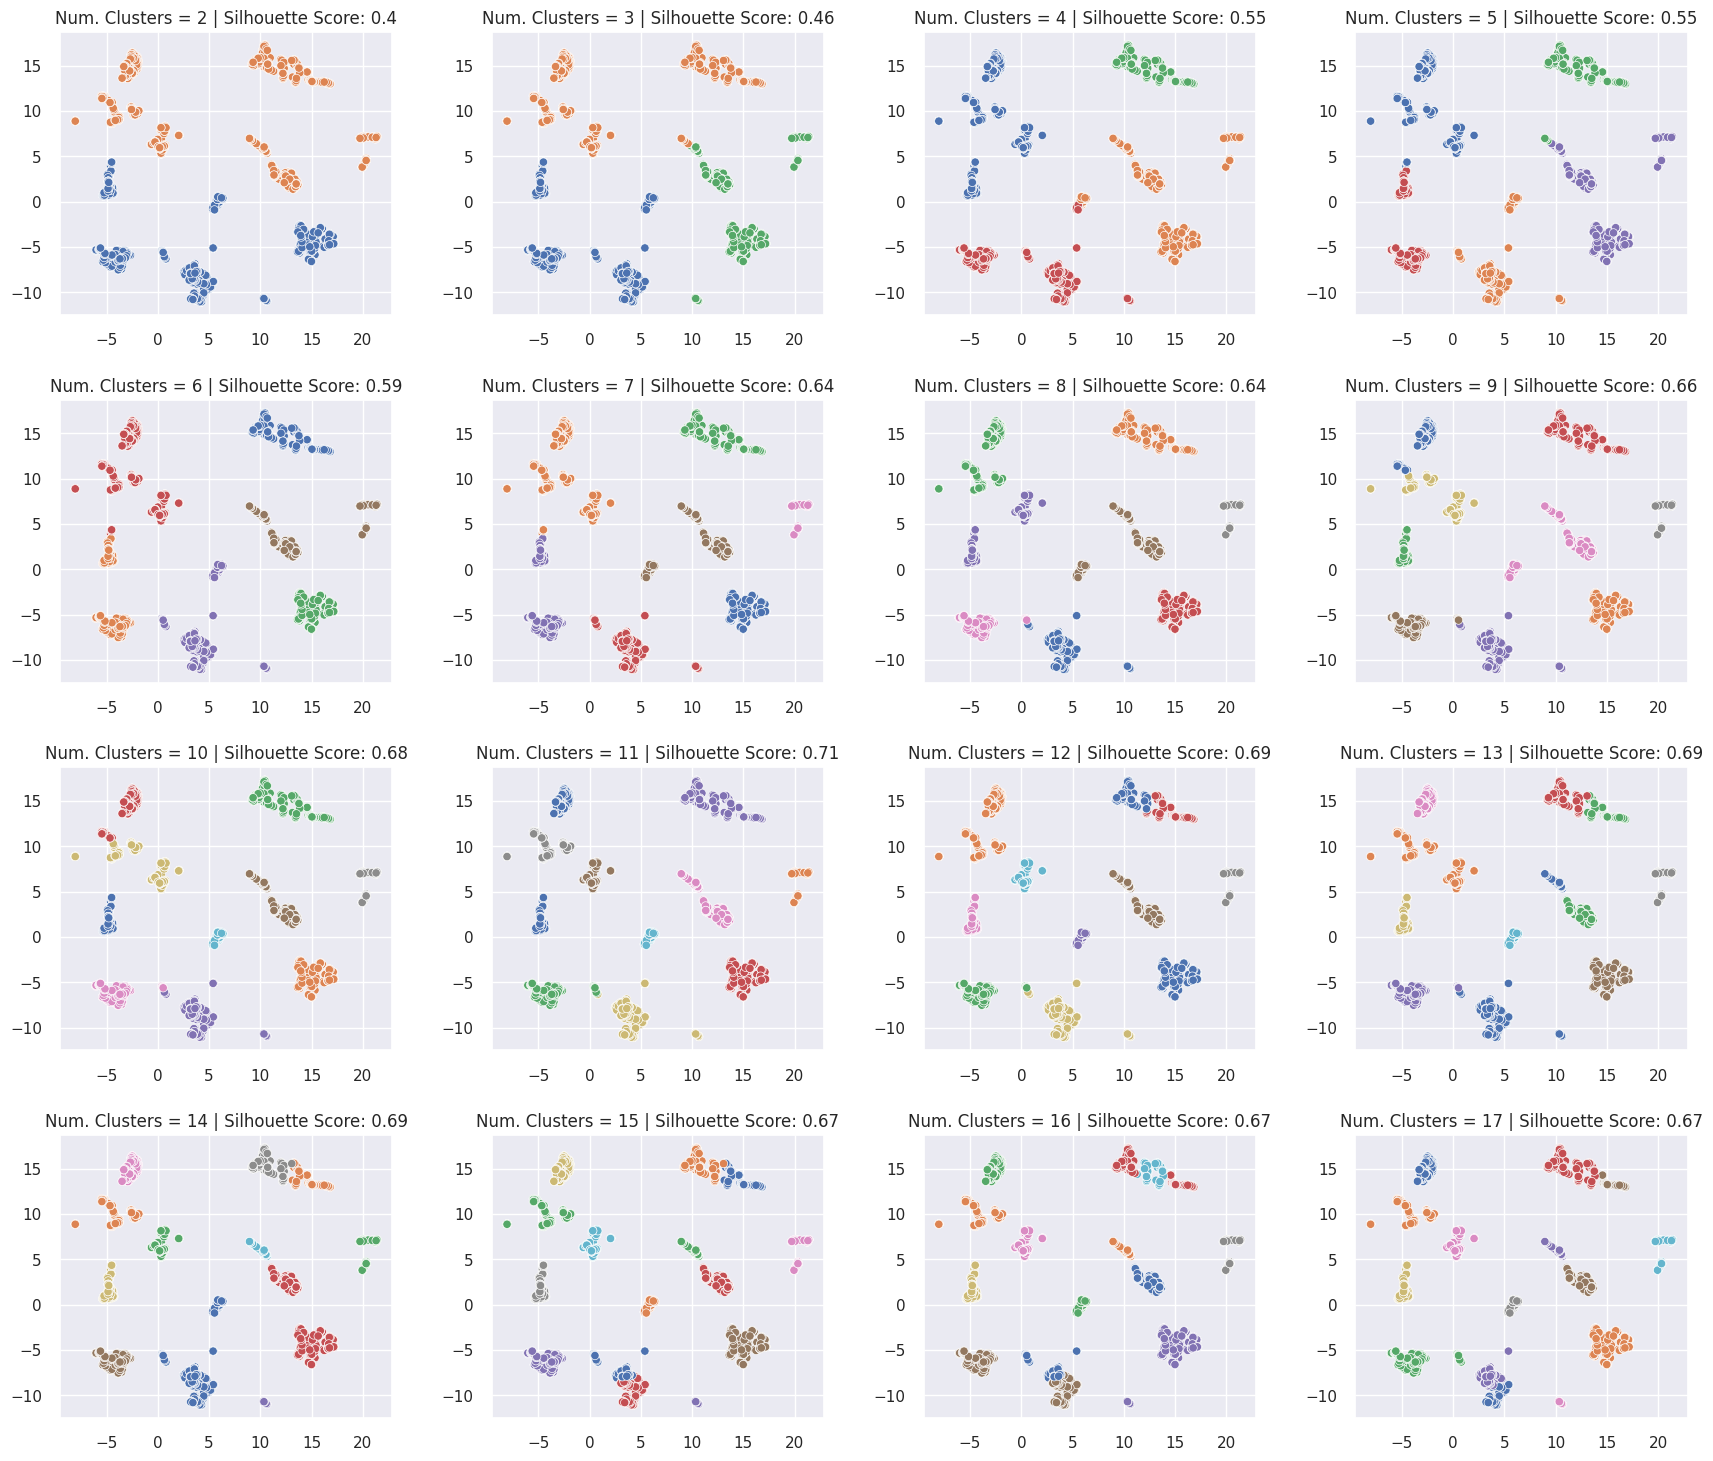

In [63]:
kmeans_labels = []

for k in clusters:
    # model definition
    kmeans_model = c.KMeans(n_clusters = k)

    # model training
    kmeans_model.fit ( X )

    # medel predict
    labels = kmeans_model.predict( X )
    
    kmeans_labels.append(labels)


# Model Analysis

plot_clusters( data = X, k = clusters, labels = kmeans_labels)

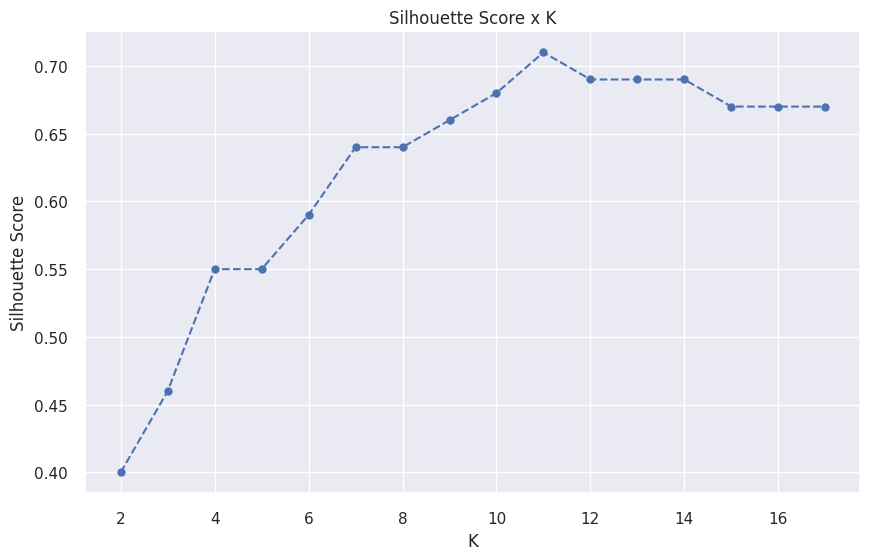

In [64]:
# Silhouette analysis

best_silhouette(data = X, k = clusters,  labels = kmeans_labels)

### 7.1.2. GMM

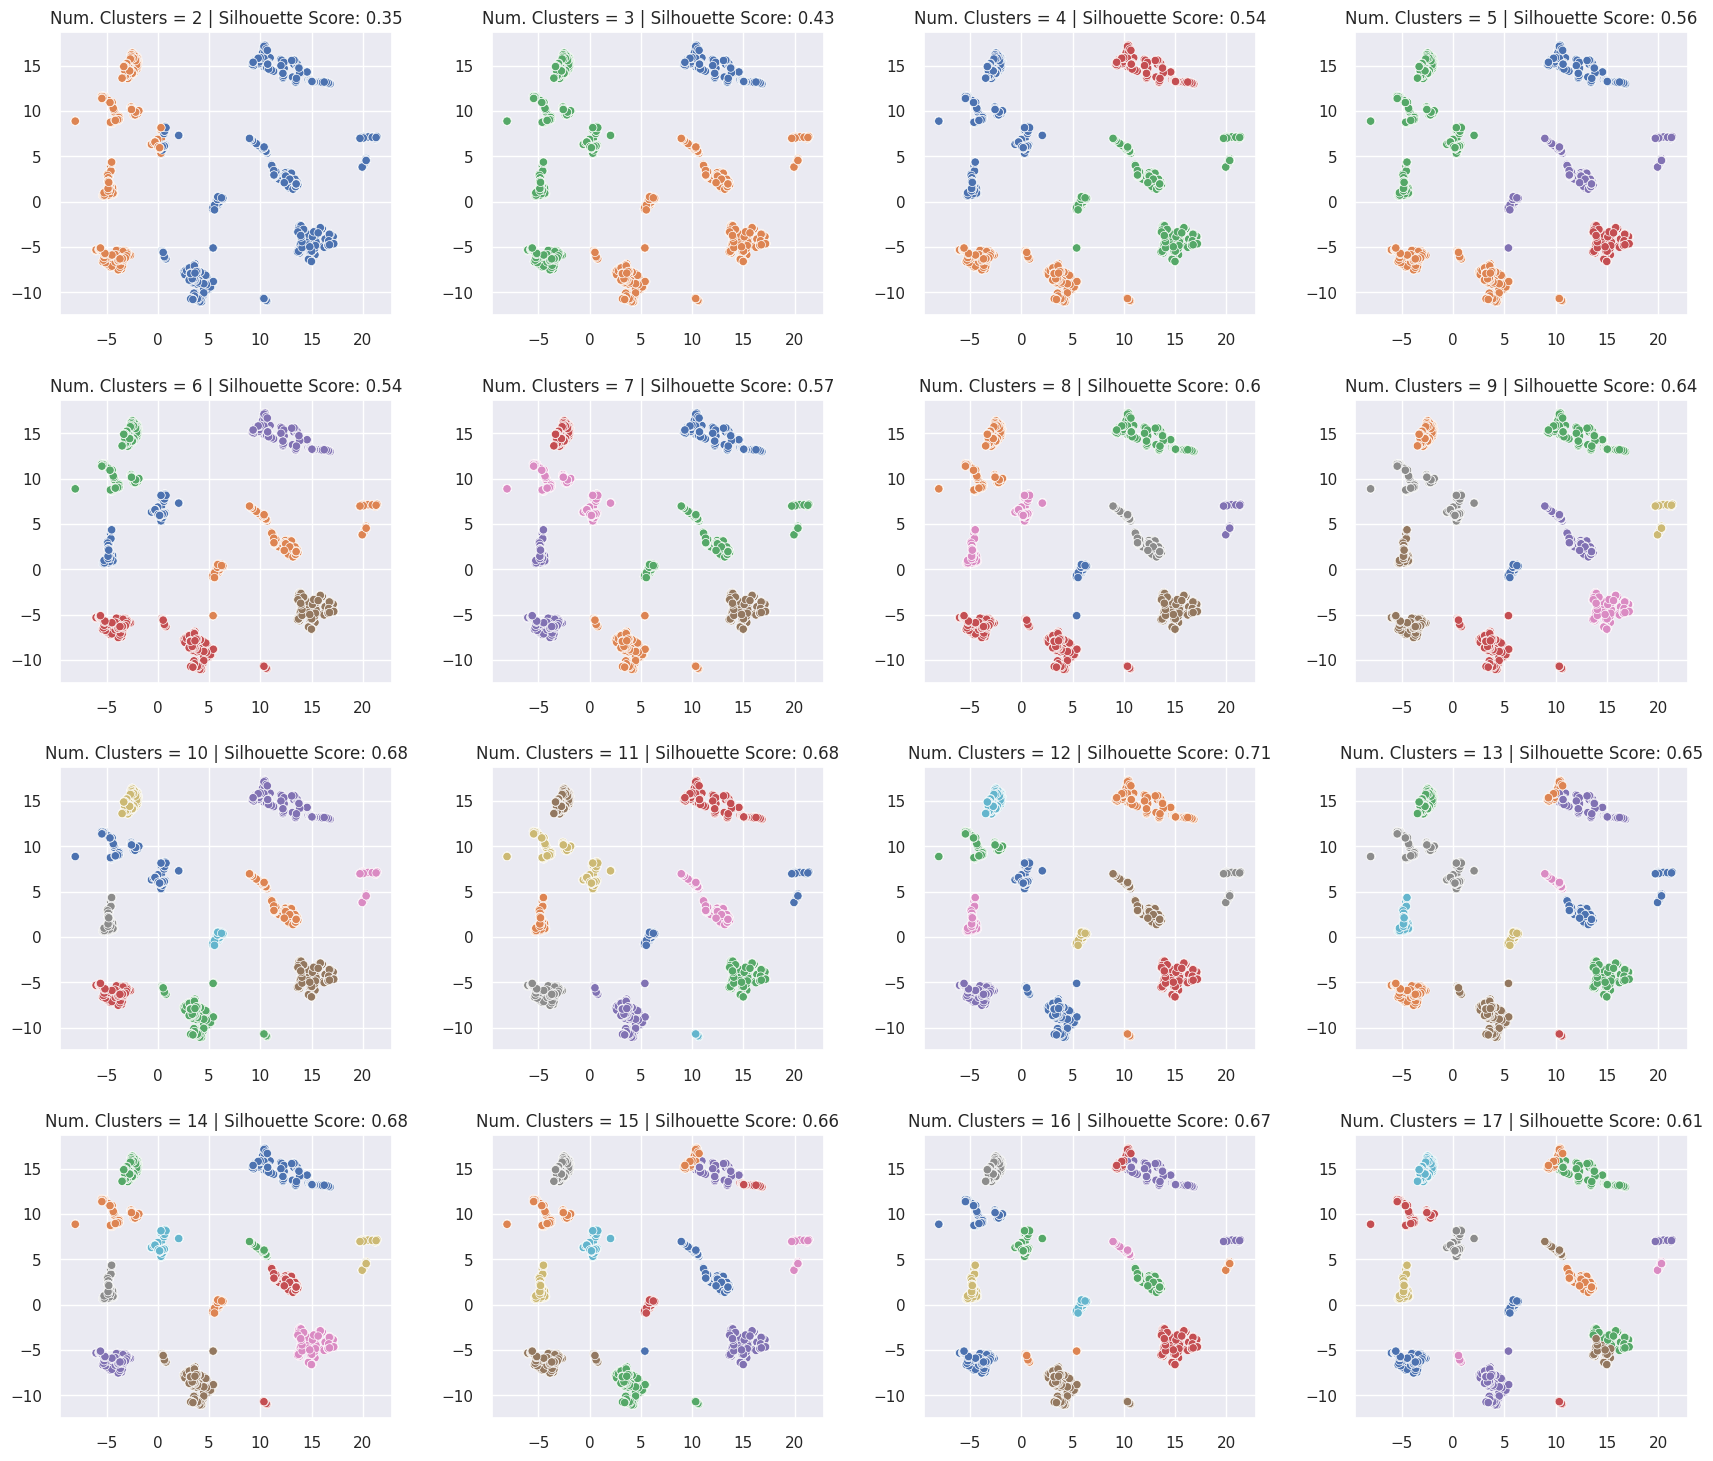

In [211]:
from sklearn import mixture as mx

gmm_labels = []

for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture( n_components = k, n_init = 30 )

    # model training
    gmm_model.fit( X )

    # model predict
    labels = gmm_model.predict( X )

    gmm_labels.append( labels )    

# Model Analysis    
plot_clusters( data = X, k = clusters, labels = gmm_labels)

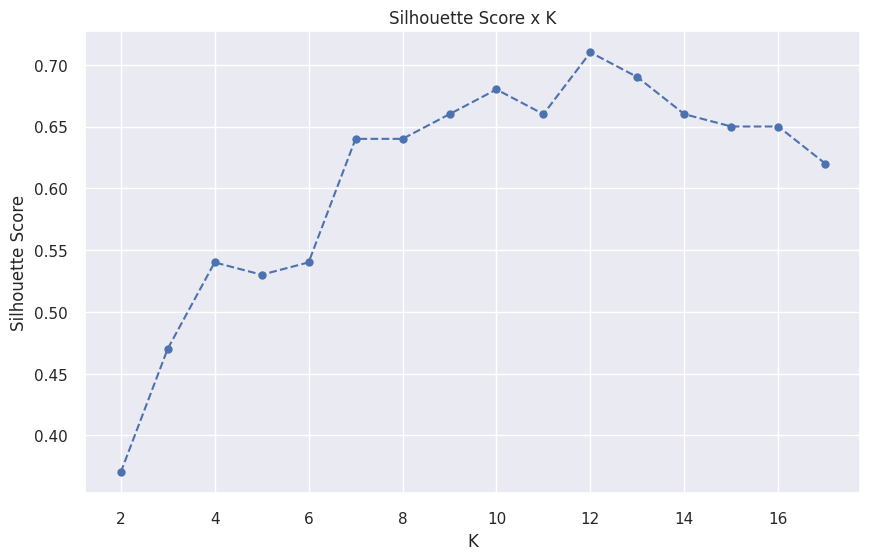

In [66]:
# Silhouette analysis
best_silhouette(data = X, k = clusters,  labels = gmm_labels)

### 7.1.3. Hierarquical Clustering

In [67]:
# model definition and training
hc_model = hc.linkage( X, 'ward')

[]

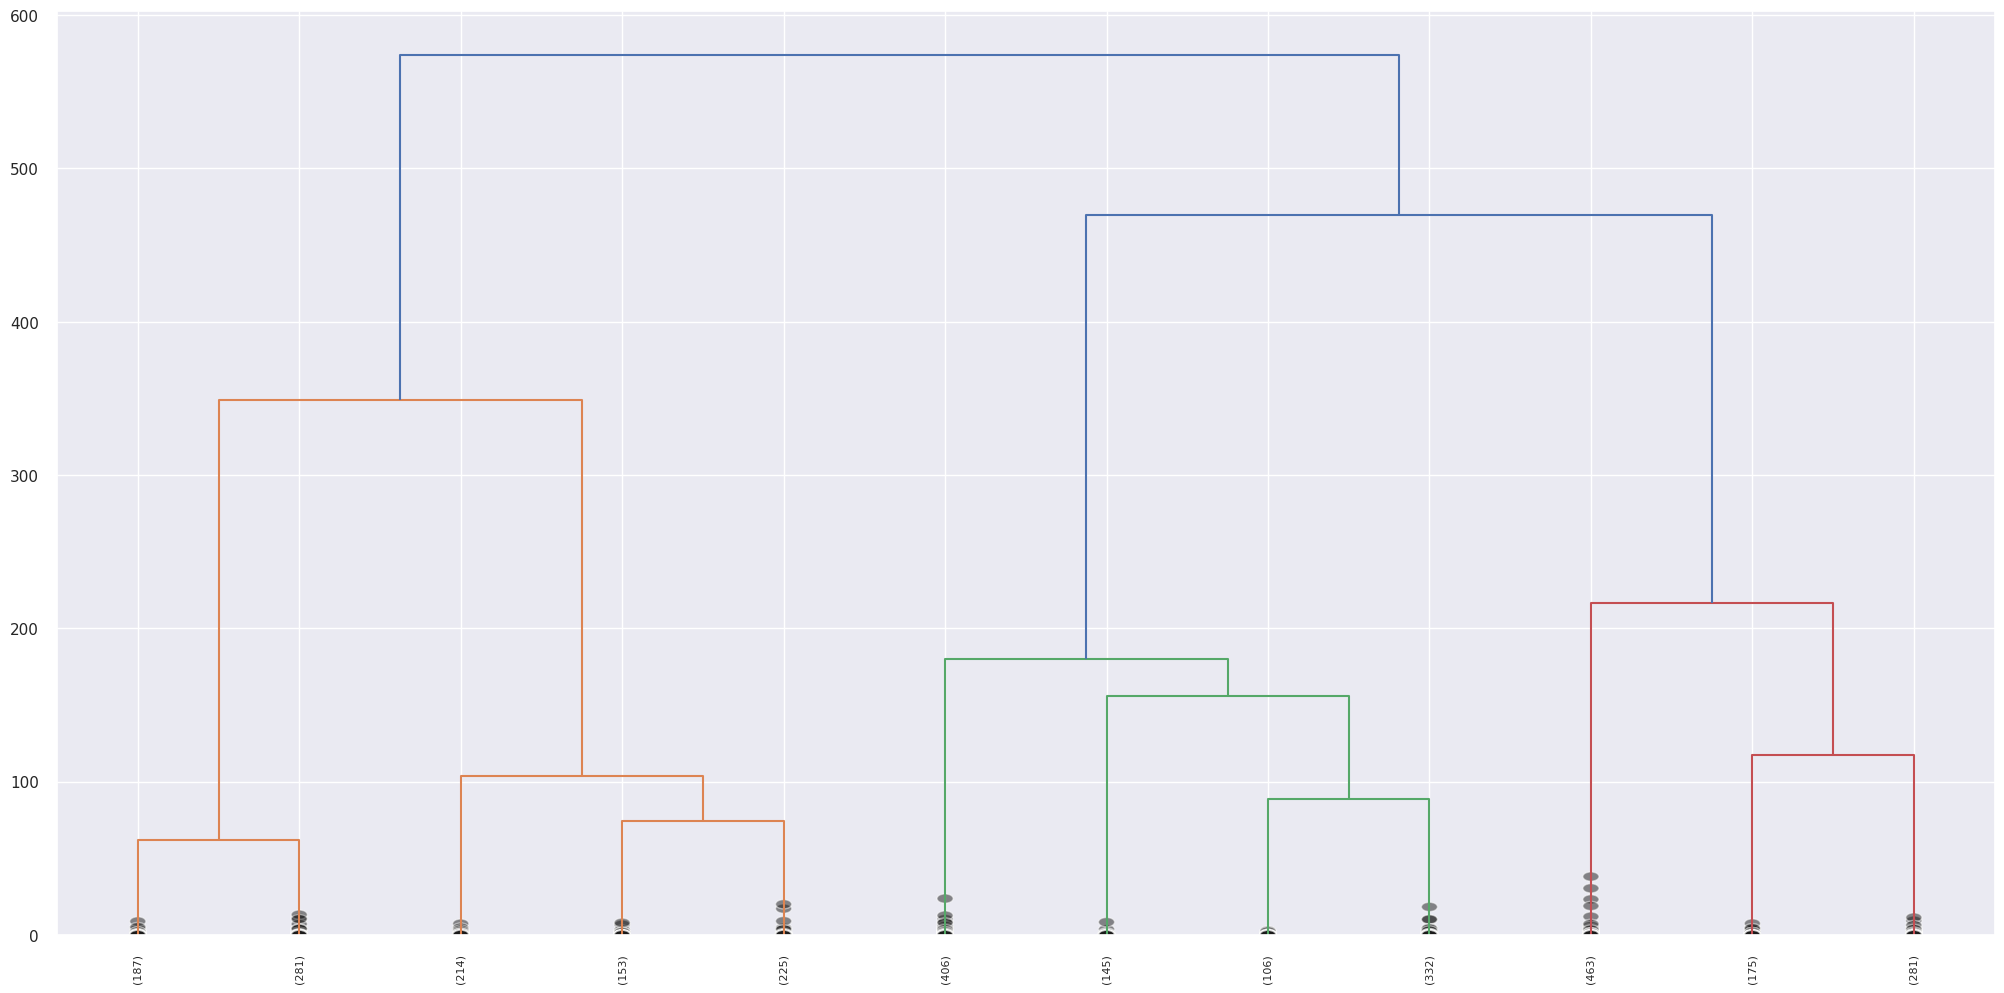

In [68]:
hc.dendrogram(
              hc_model,
              truncate_mode = 'lastp',
              p = 12,
              leaf_rotation = 90,
              leaf_font_size= 8,
              show_contracted = True
             )
plt.plot()

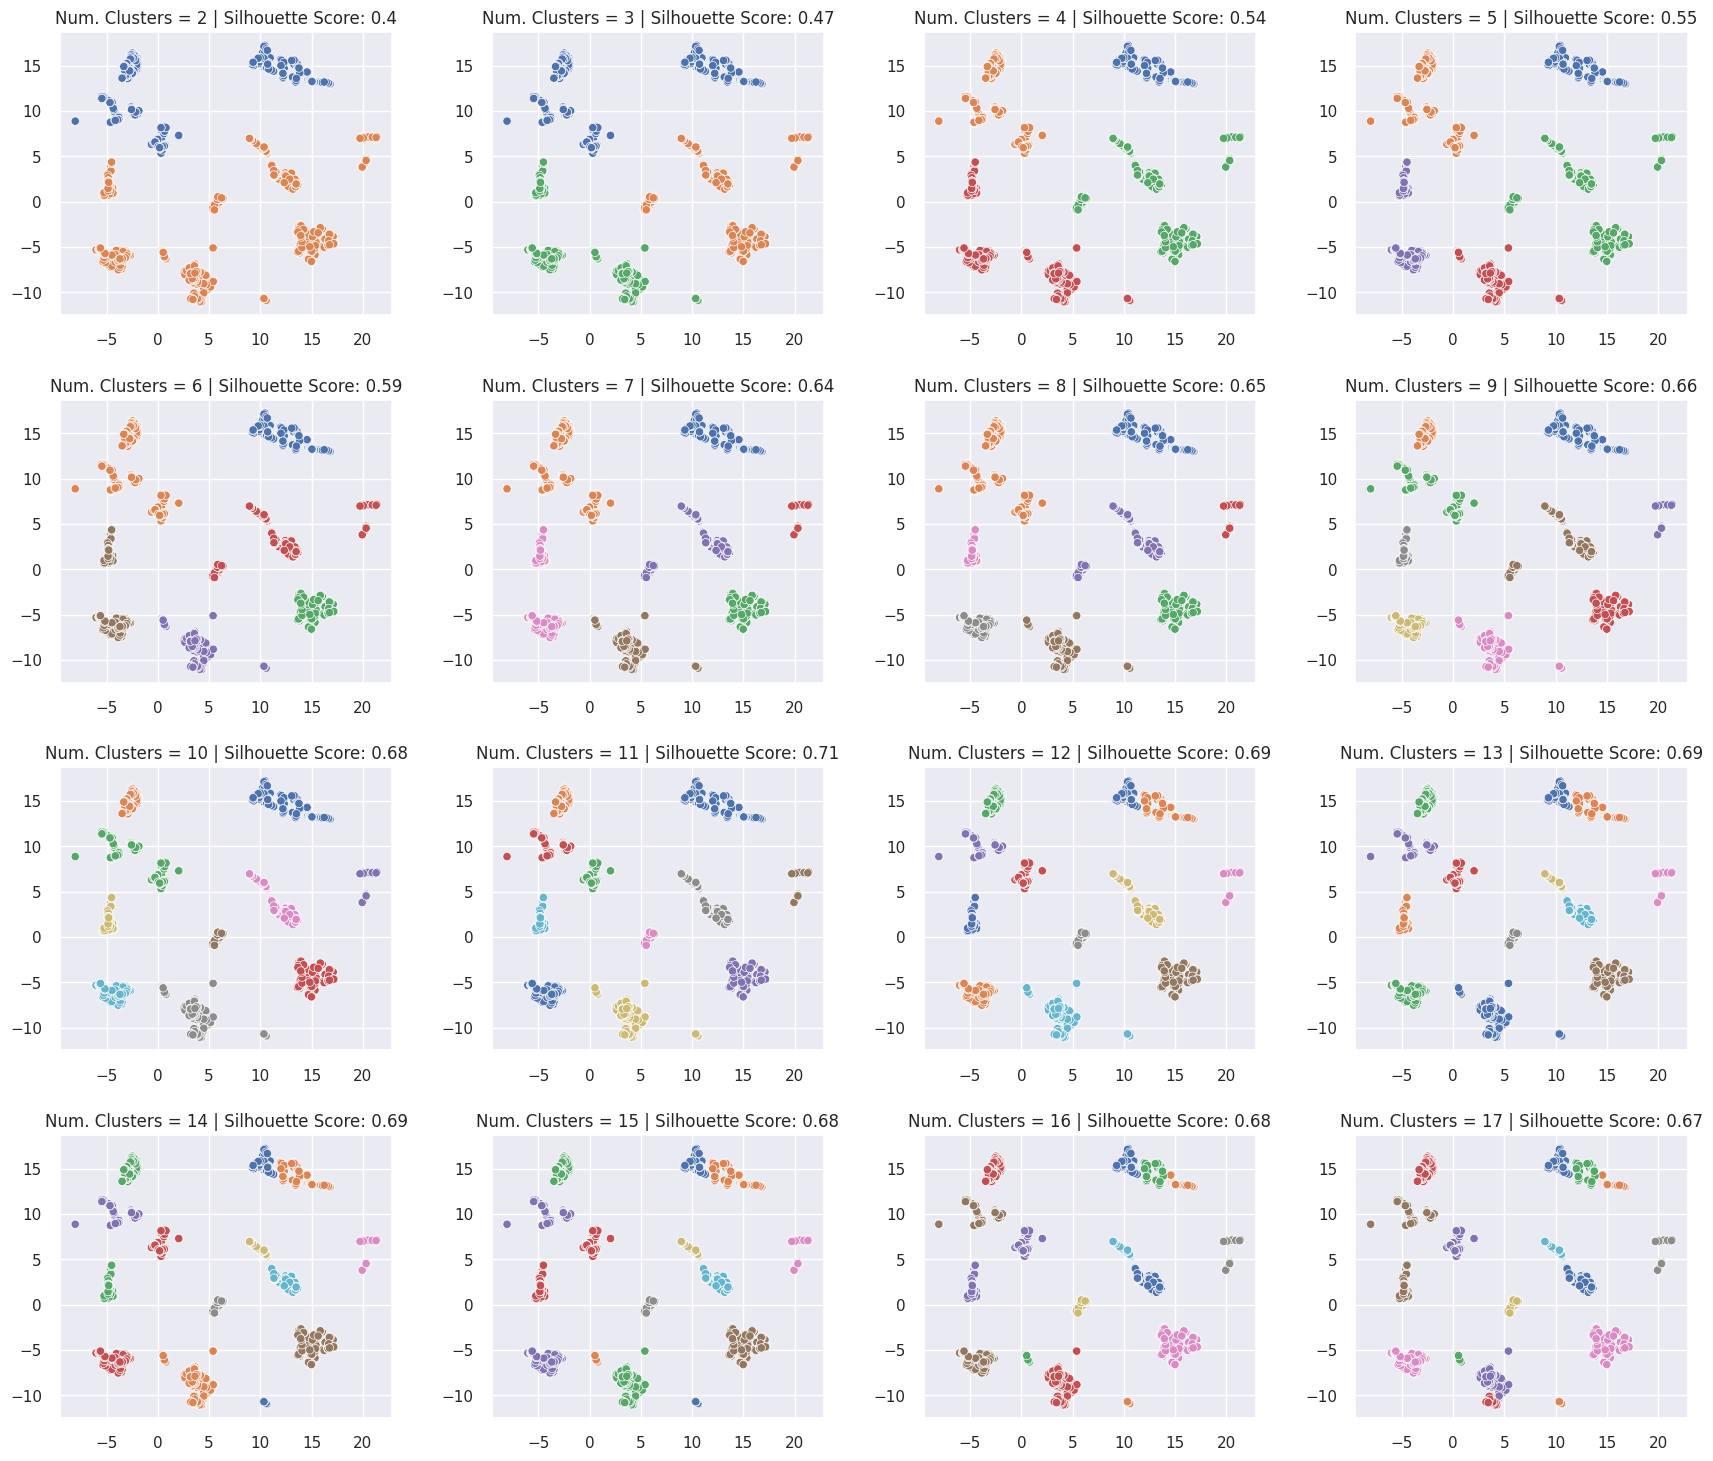

In [69]:
hclustering_labels = []

for k in clusters:
    # model definition and training
    hc_model = hc.linkage( X , 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion = 'maxclust')

    hclustering_labels.append( labels )

# Model analysis    
plot_clusters( data = X, k = clusters, labels = hclustering_labels)

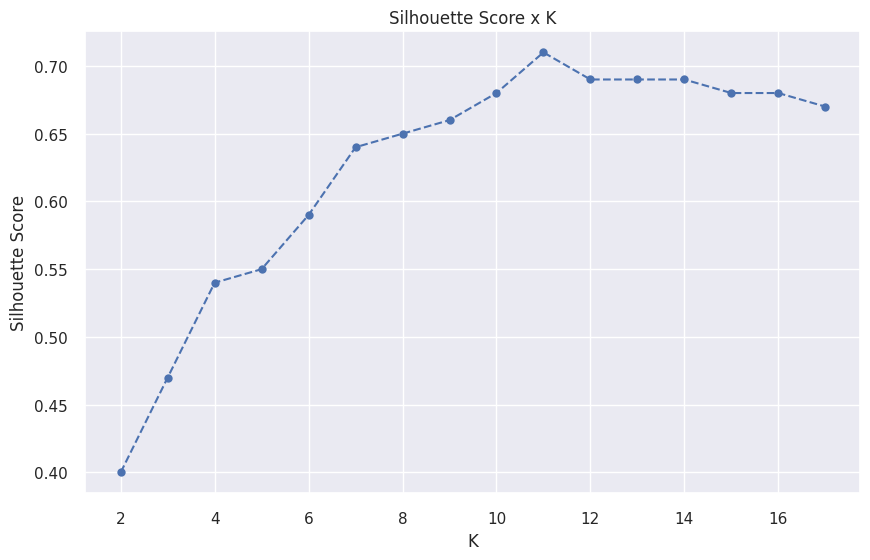

In [70]:
# Silhouette analysis
best_silhouette(data = X, k = clusters,  labels = hclustering_labels)

### 7.1.4. DBSCAN

In [71]:
eps = 3.0

min_samples = 80

# model definition
dbscan_model = c.DBSCAN( eps = eps, min_samples = min_samples)

# model training and predict
labels = dbscan_model.fit_predict( X )

sil = m.silhouette_score( X, labels, metric = 'euclidean' )
print("Silhouette score:",sil)
print( "Number of clusters:", len( np.unique( labels ) ) ) 
print( np.unique(labels))

Silhouette score: 0.67182904
Number of clusters: 10
[-1  0  1  2  3  4  5  6  7  8]


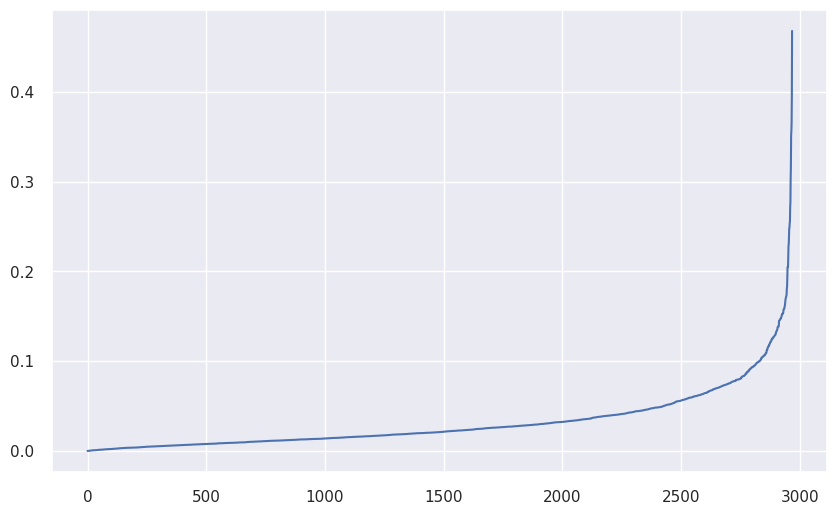

In [72]:
neighbors = NearestNeighbors( n_neighbors = min_samples ).fit( X )
distances, indexes = neighbors.kneighbors( X )
distances = np.sort( distances, axis = 0 )
distances = distances[:,1]
plt.figure( figsize = ( 10, 6 ))
plt.plot(distances)

<AxesSubplot: title={'center': 'DBSCAN K = 10 | Silhouette Score = 0.67'}, xlabel='embedding_x', ylabel='embedding_y'>

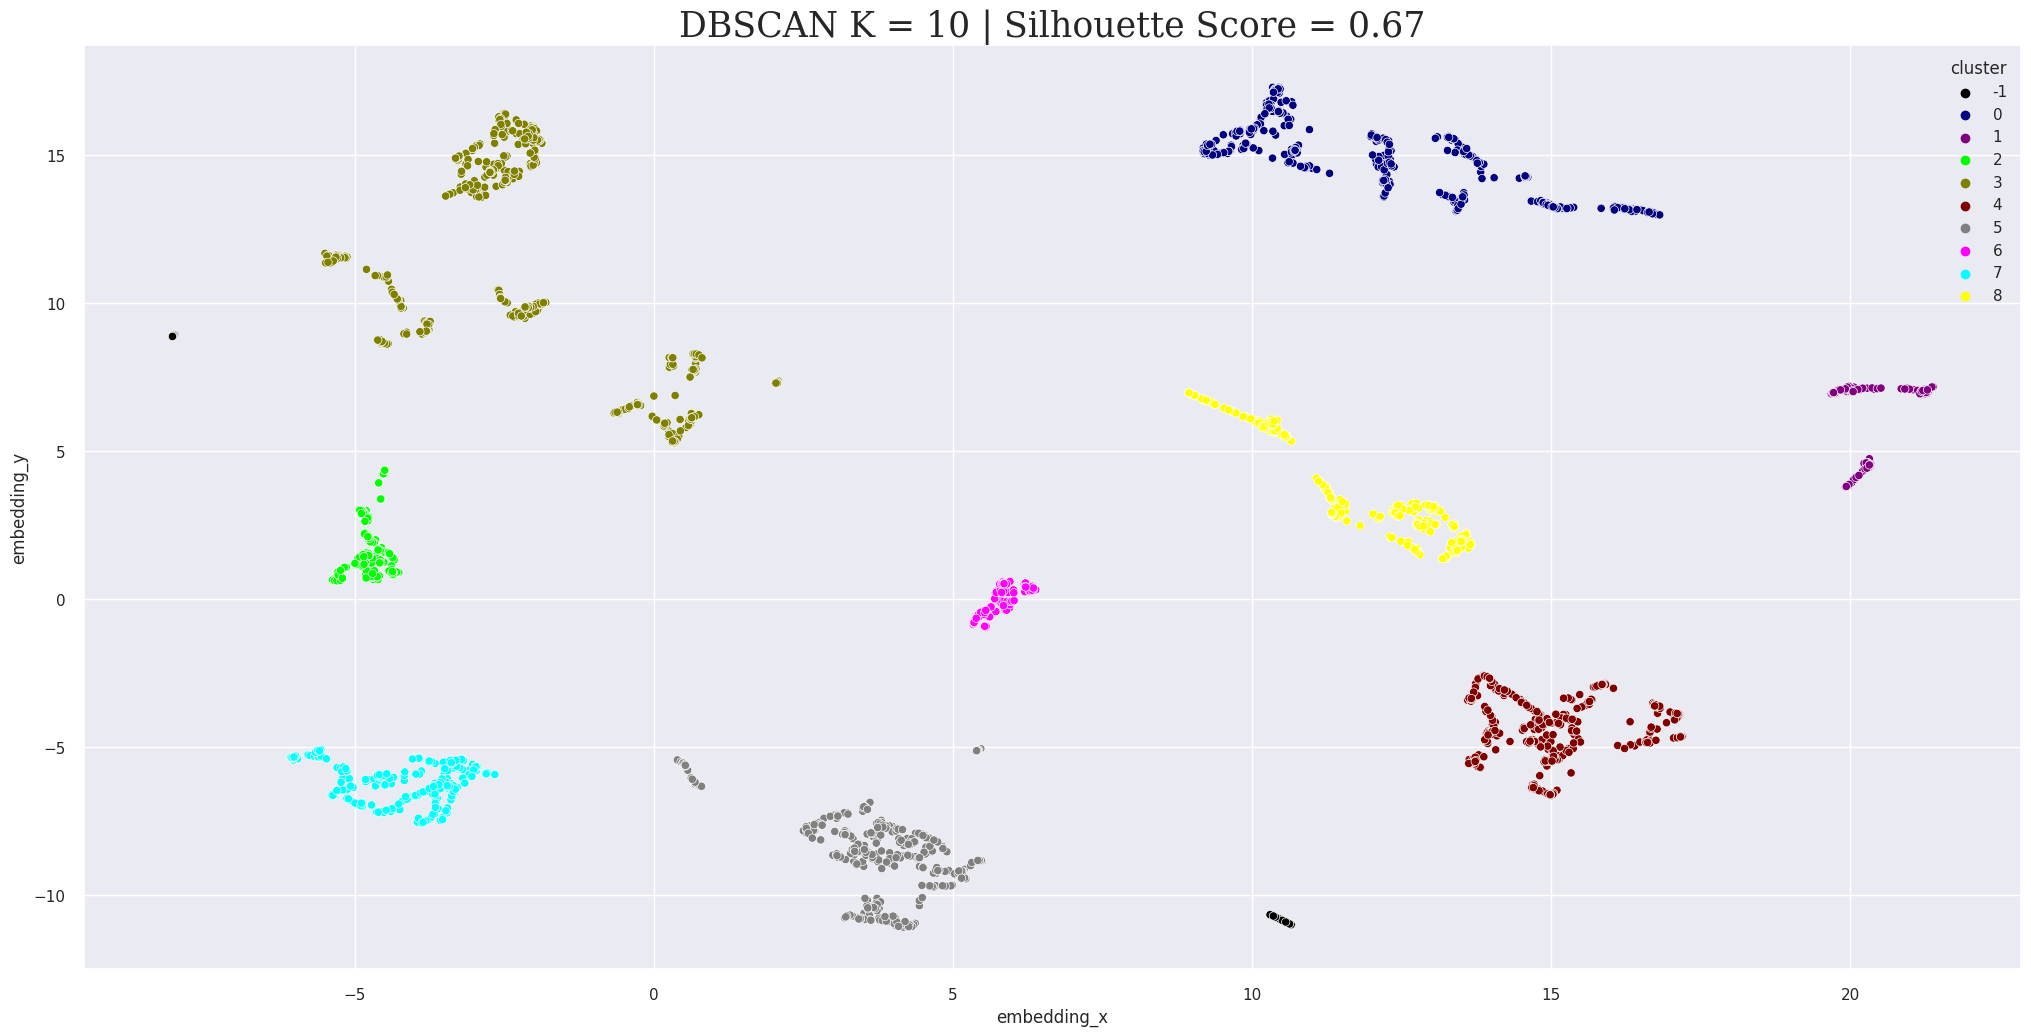

In [73]:
# Model analysis

X_dbscan = X.copy()

font = {'family': 'serif',
        'weight': 'normal',
        'size': 25,
        }

palette = ['#000000', '#000080', '#800080', '#00FF00', '#808000', '#800000', '#808080', '#FF00FF', '#00FFFF', '#FFFF00', '#FF0000', '#C0C0C0', '#6E8F9C']

X_dbscan['cluster'] = labels
plt.title("DBSCAN K = " + str(len( np.unique( labels ) )) + " | Silhouette Score = " + str(np.round(sil, 2)),fontdict = font)
sns.scatterplot(data = X_dbscan, x='embedding_x',y='embedding_y', 
                        hue = 'cluster', palette = palette, legend = True)

In [74]:
dbscan_scores = np.zeros(16)
dbscan_scores[7] = sil

### 7.1.5. HDBSCAN

In [75]:
# Model definition
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size = 85)

# Model training and predict
labels = hdbscan_model.fit_predict( X )

sil = m.silhouette_score( X, labels, metric = 'euclidean' )
print("Silhouette score:",sil)
print( "Number of clusters:", len( np.unique( labels ) ) ) 
print( np.unique(labels))

Silhouette score: 0.69689786
Number of clusters: 12
[-1  0  1  2  3  4  5  6  7  8  9 10]


<AxesSubplot: title={'center': 'HDBSCAN K = 12 | Silhouette Score = 0.7'}, xlabel='embedding_x', ylabel='embedding_y'>

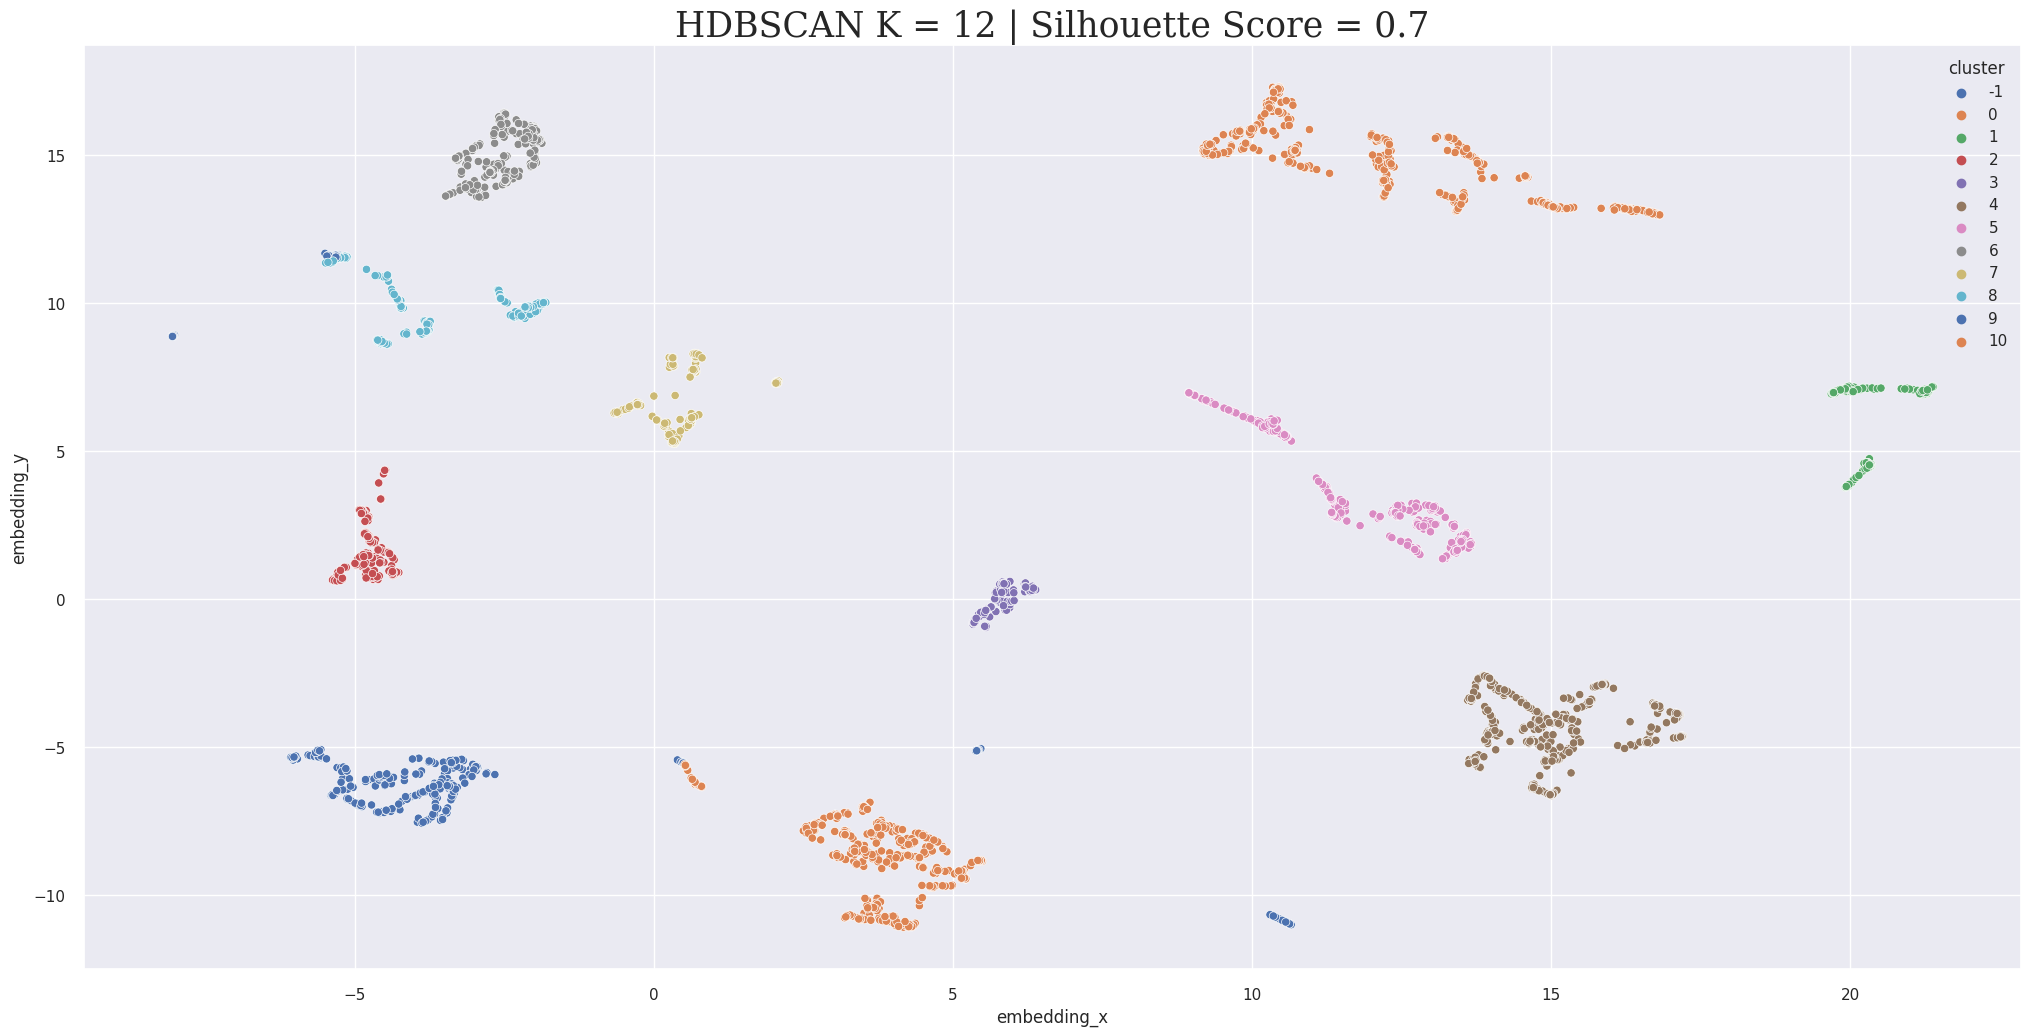

In [76]:
# Model analysis

X_hdbscan = X.copy()

font = {'family': 'serif',
        'weight': 'normal',
        'size': 25,
        }

X_hdbscan['cluster'] = labels
plt.title("HDBSCAN K = " + str(len( np.unique( labels ) )) + " | Silhouette Score = " + str(np.round(sil, 2)),fontdict = font)
sns.scatterplot(data = X_hdbscan, x='embedding_x',y='embedding_y', 
                        hue = 'cluster', palette = 'deep', legend = True)

In [77]:
hdbscan_scores = np.zeros(16)
hdbscan_scores[9] = sil

## 7.2. Results

In [212]:
kmeans_scores = get_silhouettes( X, kmeans_labels )
hclustering_scores = get_silhouettes( X, hclustering_labels )
gmm_scores = get_silhouettes( X, gmm_labels )

df_results = pd.DataFrame(
                         {'KMeans' : kmeans_scores,
                          'GMM'    : gmm_scores,
                          'HC'     : hclustering_scores,
                          'DBSCAN' : dbscan_scores,
                          'hDBSCAN': hdbscan_scores}
                         ).T
df_results.columns = clusters


In [213]:
df_results.style.highlight_max(color = 'lightgreen', axis = 1)

**Selected Model: GMM | Clusters: 10**

# 8.0. Model Training

## 8.1. GMM

In [216]:
# Model definition
k = 10
gmm_model = mx.GaussianMixture( n_components = k, n_init = 30 )
# Model training
gmm_model.fit( X )

# Clustering
labels = gmm_model.predict( X )

In [225]:
# Saving clusters labels
idx = np.argsort( gmm_model.means_.sum(axis = 1) )

new_cluster_label = np.zeros_like( idx )

clustar_name = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

new_cluster_label[idx] = clustar_name

labels = new_cluster_label[ labels ]

## 8.2. Cluster Validation

In [226]:
## WSS (Within-cluster sum of square)
print("WSS value: {}".format( kmeans.inertia_))

## SS ( Silhouette Score)
print("SS value: {}".format ( m.silhouette_score(X, labels, metric = 'euclidean' ) ) )

WSS value: 10911.515625
SS value: 0.6848666071891785


# 9.0. Cluster Analysis

In [227]:
ecommerce9 = ecommerce6.copy()
ecommerce9['cluster'] = labels

X_analysis = X.copy()
X_analysis['cluster'] = labels

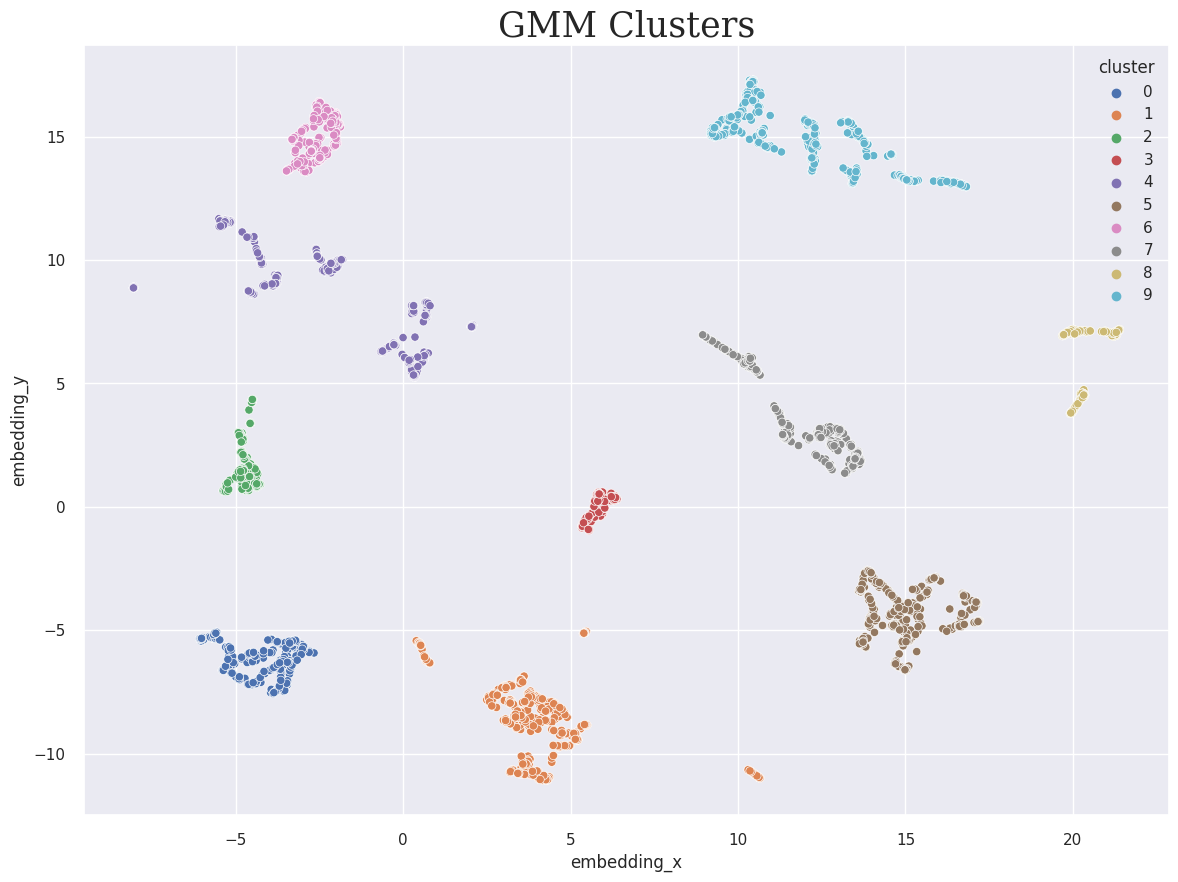

In [235]:
plt.figure(figsize=(14, 10))

plt.title("GMM Clusters",fontdict = font)
sns.scatterplot(data = X_analysis, x='embedding_x',y='embedding_y', 
                        hue = 'cluster', palette = 'deep', legend = False)

sns.scatterplot(data = X_analysis, x='embedding_x',y='embedding_y', hue = 'cluster', palette = 'deep' );



## 9.1. Visual Inspection

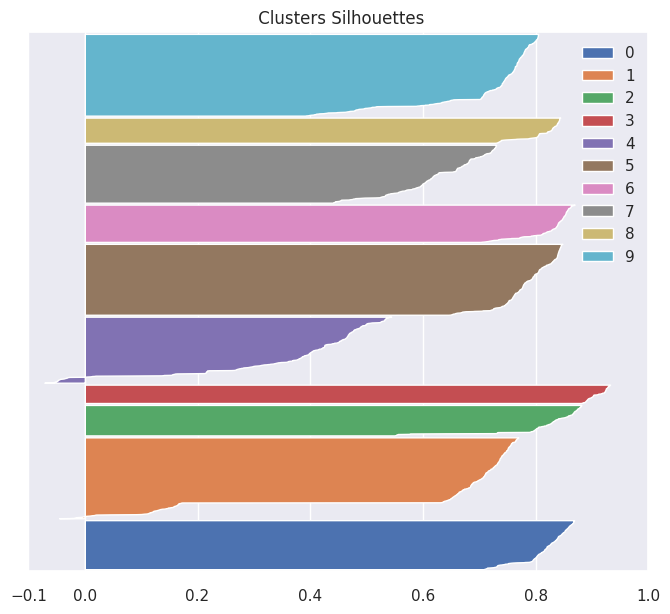

In [247]:
plot_cluster_silhouette(X, labels, 10)

## 9.2. 2d plot

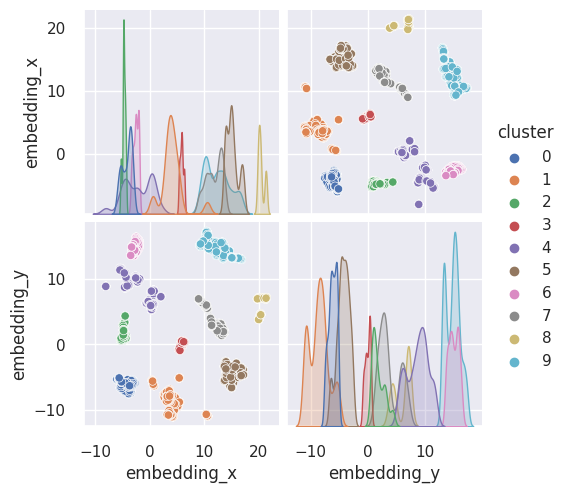

In [248]:
sns.pairplot(X_analysis, hue = 'cluster', palette = 'deep')

## 9.3. Cluster Profile

In [249]:
ecommerce9 = ecommerce4.copy()
ecommerce9['cluster'] = labels

# Number of customers
no_customers = ecommerce9[['customer_id','cluster']].groupby('cluster').count().reset_index()
no_customers['percentage'] = ( no_customers['customer_id'] /  no_customers['customer_id'].sum() ) * 100

# AVG Gross Revenue
class_gross_revenue = ecommerce9[['gross_revenue','cluster']].groupby('cluster').mean().reset_index().rename(columns = {'gross_revenue':'avg_gross_revenue'})
df_cluster = pd.merge(no_customers, class_gross_revenue, how = 'inner', on = 'cluster')

# AVG Recency days
class_recency = ecommerce9[['recency','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, class_recency, how = 'inner', on = 'cluster')

# AVG invoices
class_invoices = ecommerce9[['qtty_products','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, class_invoices, how = 'inner', on = 'cluster')

# Frequency
class_frequency = ecommerce9[['frequency','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, class_frequency, how = 'inner', on = 'cluster')

# Returns
class_returns = ecommerce9[['qtty_returns','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, class_returns, how = 'inner', on = 'cluster')

# Percentual Gross Revenue
perc_gross_revenue = ecommerce9[['gross_revenue','cluster']].groupby('cluster').sum().reset_index()
perc_gross_revenue['percentual_gross_revenue'] = ( perc_gross_revenue['gross_revenue'] /  perc_gross_revenue['gross_revenue'].sum() ) * 100
df_cluster = pd.merge(df_cluster, perc_gross_revenue, how = 'inner', on = 'cluster')

In [258]:
df_cluster

cluster  customer_id  percentage  avg_gross_revenue     recency  \
0        0          281    9.467655         956.602883   78.348754   
1        1          463   15.599730        2134.216263   55.883369   
2        2          175    5.896226         827.478286   92.022857   
3        3          106    3.571429        1454.785283   63.245283   
4        4          378   12.735849         508.854418  153.111111   
5        5          406   13.679245        1689.882315   54.731527   
6        6          214    7.210243         633.109486   47.453271   
7        7          332   11.185984        2500.743946   44.864458   
8        8          145    4.885445        3164.253379   34.427586   
9        9          468   15.768194        8836.136389   21.438034   

   qtty_products  frequency  qtty_returns  gross_revenue  \
0      36.587189   0.058879      5.661922      268805.41   
1      67.710583   0.038461     11.924406      988142.13   
2      26.822857   0.068111     22.868571      144808.70   
3      67.273585   0.050609     25.462264      154207.24   
4      15.738095   0.223146      9.600529      192346.97   
5      89.290640   0.049327     11.504926      686092.22   
6      11.392523   0.028667      1.130841      135485.43   
7     128.201807   0.051815     23.885542      830246.99   
8     173.875862   0.087495     23.482759      458816.74   
9     424.134615   0.067650    149.271368     4135311.83   

   percentual_gross_revenue  
0                  3.362479  
1                 12.360640  
2                  1.811408  
3                  1.928974  
4                  2.406062  
5                  8.582307  
6                  1.694783  
7                 10.385534  
8                  5.739325  
9                 51.728489

In [252]:
labels_description = {
                        9:  "Insiders",
                        8:  "More Products",
                        7:  "More products & more often",
                        1:  "More often",
                        5:  "More expensive products",
                        3:  "More products & Less returns",
                        0:  "Even more products",
                        2:  "Less Returns",
                        6:  "More and more products & more often",
                        4:  "More products ( sleeping )",
                     }


### Cluster 9: Insider Candidades 

    - Customers: 468 (16% of the customers)
    - AVG Recency:21 days
    - AVG products: 424
    - Frequency: 0.06
    - AVG Revenue: $ 8836.14
    - AVG Returns: 149
    
### Cluster 8: More Products 

    - Customers: 145 (5% of the customers)
    - AVG Recency:34 days
    - AVG products: 174
    - Frequency: 0.08
    - AVG Revenue: $ 3164.25
    - AVG Returns: 23
    
### Cluster 7: More products & more often

    - Customers: 332 (11% of the customers)
    - AVG Recency:45 days
    - AVG products: 128
    - Frequency: 0.05
    - AVG Revenue: $ 2501.00
    - AVG Returns: 24
    
### Cluster 1: More often

    - Customers: 463 (16% of the customers)
    - AVG Recency:56 days
    - AVG products: 68
    - Frequency: 0.04
    - AVG Revenue: $ 2134.21
    - AVG Returns: 12
    
### Cluster 5: More expensive products 

    - Customers: 406 (14% of the customers)
    - AVG Recency:55 days
    - AVG products: 89
    - Frequency: 0.05
    - AVG Revenue: $ 1689.88
    - AVG Returns: 12
    
### Cluster 3: More products & Less returns 

    - Customers: 106 (4% of the customers)
    - AVG Recency:63 days
    - AVG products: 67
    - Frequency: 0.05
    - AVG Revenue: $ 1455.00
    - AVG Returns: 25
   
### Cluster 0: Even more products

    - Customers: 281 (9% of the customers)
    - AVG Recency:78 days
    - AVG products: 37
    - Frequency: 0.06
    - AVG Revenue: $ 956.60
    - AVG Returns: 6
    
### Cluster 02: Less Returns 

    - Customers: 175 (6% of the customers)
    - AVG Recency:47 days
    - AVG products: 27
    - Frequency: 0.07
    - AVG Revenue: $ 827.48
    - AVG Returns: 23

### Cluster 6: More and more products & more often

    - Customers: 214 (7% of the customers)
    - AVG Recency:107 days
    - AVG products: 11
    - Frequency: 0.03
    - AVG Revenue: $ 633.11
    - AVG Returns: 1
    
### Cluster 4: More products ( sleeping )

    - Customers: 378 13% of the customers)
    - AVG Recency:153 days
    - AVG products: 16
    - Frequency: 0.2
    - AVG Revenue: $ 508.85
    - AVG Returns: 10

# 10.0. Exploratory Data Analysis

In [260]:
ecommerce10 = ecommerce4.copy()
ecommerce10['cluster'] = labels

## 10.1 Hypotesis Mindmap

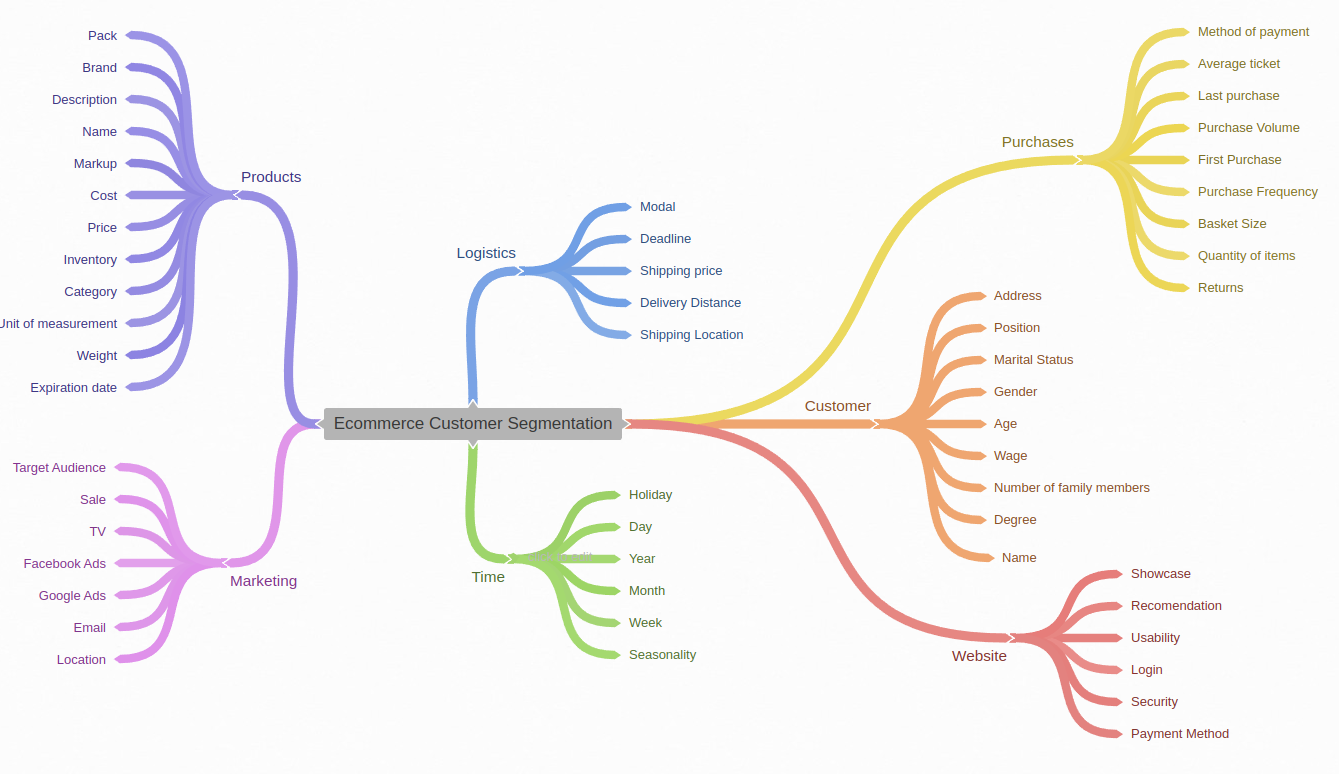

In [191]:
Image('../img/ecommerce_mindmap.png')

## 10.2. Business Hypotesis

### 10.2.1. Purchases

**1.** 80% of the Insiders use credit cars as payment method.

**2.** The "Insiders" cluster  customers have an average ticket 10% greater than the "more products" cluster.

**3.** The "Insiders" cluster customers have basket size with more than 5 products.

**4. The "Insiders" cluster customers have a purchase volume over 10% of the total of purchases.**

**5. The "Insiders" cluster customers have a turnover over 10% of the total.**

**6. The "Insiders" cluster customers have return rate under the average of all customers.**

**7. The median of the price of the products bought by the Insiders is 10% greater than the median of all the purchases.**

**8. The percetile of the Insiders gmv.**

### 10.2.2. Product

**1.** 30% of the biggest packs are bought by the Insiders.

**2.** The median of the price of the products bought by the Insiders is 10% greater than the median of all the purchases.

**3.** The percetile of the price of the products bought by the Insiders.

**4.** The average weight of the products bought by the Insiders is greater than average of the other clusters.

**5.** Insiders are used to buy newer products than the other clusters. 


### 10.2.3. Customer

**1.** 60% of the Insiders are single.

**2.** 70% of the Insiders are 24 to 35 years old.

**3.** The "Insiders" cluster  customers have an average ticket 10% greater than the "more products" cluster.

**3.** The "Insiders" cluster customers have basket size with more than 5 products.

**4.** 40% of the Insiders delivers are in a radius of 50km.

**5.** 5% of the Isiders customers earn more than 100k / year.


## 10.3. Hypotesis selection

#### H4: The "Insiders" cluster customers have a purchase volume over 10% of the total of purchases.
**True**

In [261]:
# Sum of insiders products
prod_insiders = ecommerce10[ecommerce10['cluster'] == 9]['qtty_products'].sum()

# Sum total of products
prod_total = ecommerce10['qtty_products'].sum()

# Percentage Insiders products products
print( "% Sales Insiders: ",np.round(prod_insiders * 100 / prod_total,2), " of the total.")

% Sales Insiders:  54.48  of the total.


#### H5:  The "Insiders" cluster customers have an income over 10% of the total.
**True**

In [262]:
# Sum of insiders gross revenue
gr_insiders = ecommerce10[ecommerce10['cluster'] == 9]['gross_revenue'].sum()

# Sum total gross revenue
gr_total = ecommerce10['gross_revenue'].sum()

# Percentage Insiders products products
print( "% Gross revenue Insiders: ",np.round(gr_insiders * 100 / gr_total,2), " of the total.")

% Gross revenue Insiders:  51.73  of the total.


#### H6: The "Insiders" cluster customers have an average number of returns under the average of all customers.
**False**

In [263]:
returns_insiders = ecommerce10[ecommerce10['cluster'] == 9]['qtty_returns'].mean()
returns_total = ecommerce10['qtty_returns'].mean()

print("Average returns insiders: ", np.round(returns_insiders,2), " Average returns all: ", np.round(returns_total,2))

Average returns insiders:  149.27  Average returns all:  34.89


#### H7: The median of the Insiders revenue is more than 10% greater than the median of all the customers.
**True**

In [264]:
median_insiders = ecommerce10[ecommerce10['cluster'] == 9]['gross_revenue'].median()
median_all = ecommerce10['gross_revenue'].median()

print("The median of the Insiders revenue is ", np.round(((median_insiders / median_all) * 100) - 100, 2),"% greater than the median of all the customers.")

The median of the Insiders revenue is  276.48 % greater than the median of all the customers.


#### H8: The the majority of Insiders gmv are in the 3rd quartile.
**False**

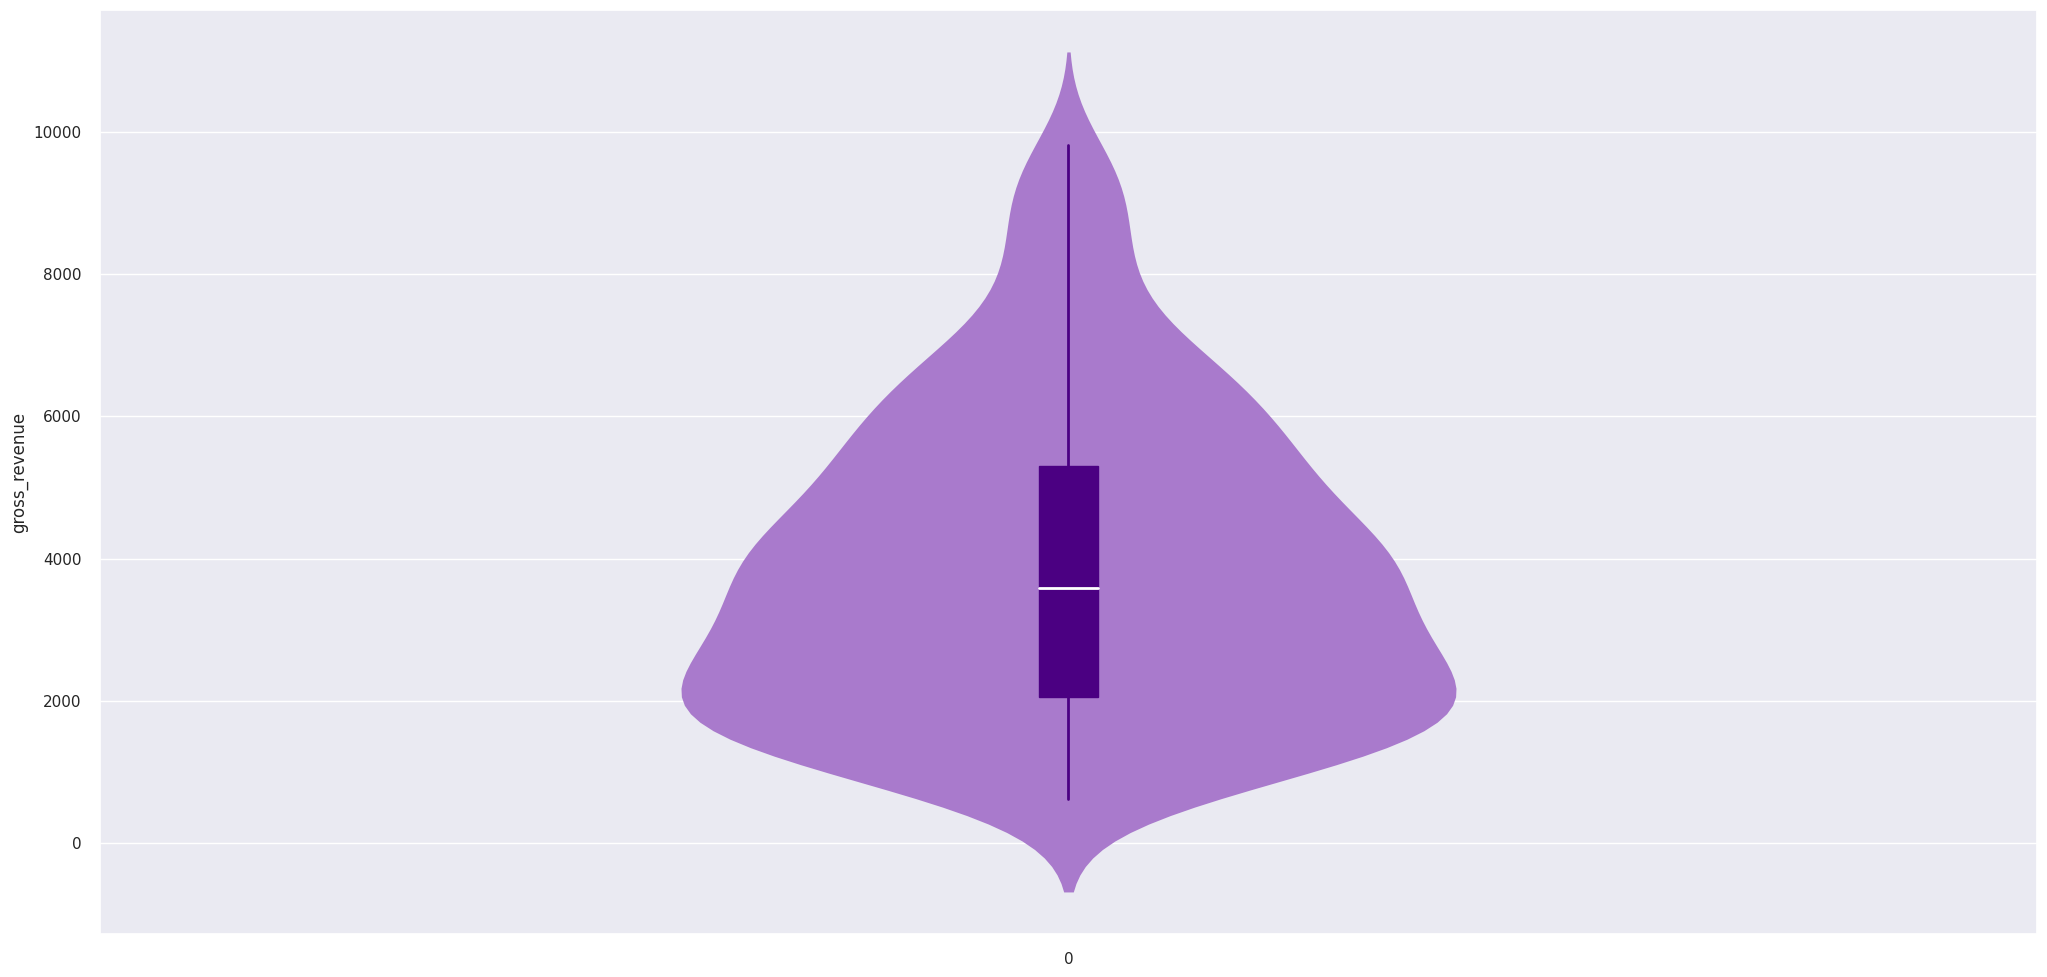

In [265]:
fig, axes = plt.subplots()

# Seaborn violin plot
sns.violinplot(y = gmv_insiders, color="#af52f4", inner = None, linewidth=0, saturation=0.5)

# Normal boxplot has full range, same in Seaborn boxplot
axes.boxplot(gmv_insiders, positions=np.array([0]),
            showcaps = False, widths = 0.06, patch_artist=True,
            boxprops=dict(color="indigo", facecolor="indigo"),
            whiskerprops=dict(color="indigo", linewidth=2),
            medianprops=dict(color="w", linewidth=2 ))

axes.set_xlim(-1,1)

plt.show()

## 10.4. Business Questions

**1. who are the people eligible for the loyalty program?**

In [266]:
insiders = ecommerce10[ecommerce10['cluster'] == 9]['customer_id']
insiders.head()

1430    17850
1432    12583
1436    14688
1438    15311
1442    16029
Name: customer_id, dtype: int64

**2. How many customers will be able to join the group?**

In [267]:
insiders.count()

468

**3. What are the main features of these customers?**

### Cluster 05: Insider Candidades 

    - Customers: 468 (16% of the customers)
    - AVG Recency:21 days
    - AVG products: 424
    - Frequency: 0.06
    - AVG Revenue: $ 8836.14
    - AVG Returns: 149

**4. How much do the Insiders contribute to the total billing amount?**

In [268]:
insiders_gnv = ecommerce10[ecommerce10['cluster'] == 9]['gross_revenue'].sum()
all_gnv = ecommerce10['gross_revenue'].sum()

print("Insiders contribution:",np.round(insiders_gnv * 100/ all_gnv, 2),"%")

Insiders contribution: 51.73 %


**5. Whet is the Insider's billing forecast for the coming months?**

**6. What are the conditions to someone be elegible to the Insiders group?**